In [1]:
import math
import warnings

import matplotlib.pyplot as plt
import numpy as np
import palettable
import pandas as pd
import pybedtools
import statsmodels.api as sm
import statsmodels
from liftover import get_lifter
from matplotlib import patches
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import seaborn as sns
from scipy import stats

bold_10 = palettable.cartocolors.qualitative.Bold_10.mpl_colors

from scripts import aesthetics, sv_plot

aesthetics.activate_paper_rcParams()

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

%reload_ext autoreload
%autoreload 2

# Initial look

The goal of this notebook is just to do an initial characterization of structural variants that are in the vicinity of EWSR1 and FLI1. We'll do the actual implementation of whatever framework we decide to use elsewhere, this is just to get acquainted with the formatting and layouts of SVs.

# More on the EWSR1-FLI1 fusion

Central to this endeavor will be identifying the location of the EWSR1-FLI1 fusion. A little more on these genes specifically:

__EWSR1 (chr22:29268268-29300521)__

This gene "acts in various cellular processes, including gene expression, cell signaling, and RNA processing and transport. The protein includes an N-terminal transcriptional activation domain and a C-terminal RNA-binding domain."

EWSR1 has 17 exons and spans 32kb (656 AA). There are at least three isoforms that have been described--a full length, one with a minor (1 AA) C terminal difference, and one that lacks exon 6.

__FLI1 (chr11:128694072-128813267)__

FLI1 is a transcription factor that contains ETS DNA-binding domain. It is the portion of the fusion that is responsible for the transcriptional derangement in Ewing's. FLI1 is quite large, with 9 exons and spanning 119kb (452 AA). There are a handful of isoforms, mostly those that lack exon 4.

## So where is the fusion?

I've spent some time looking at prior studies that characterized this fusion to find the exact breakpoints, and here are a few studies that I've found:

- https://pubmed.ncbi.nlm.nih.gov/25223734/  
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC413872/ (an old study from 1993 that used restriction enzymes to map the fusion)  
- Riaz's personal cohort.

In [2]:
gtf = pd.read_csv(
    "https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_43/gencode.v43.basic.annotation.gtf.gz",
    comment="#",
    sep="\t",
    header=None,
    names=[
        "seqname",
        "source",
        "feature",
        "start",
        "end",
        "score",
        "strand",
        "frame",
        "attribute",
    ],
)

In [3]:
# EWSR1-203 and FLI1-205 are the full length transcripts (they have tons of splice variants)
gene_gtfs = {}
gene_attrs = {"EWSR1": "EWSR1-203", "FLI1": "FLI1-205"}
for g, g_attr in gene_attrs.items():

    # extract all elements of the gene
    gene_gtfs[g] = gtf[(gtf["attribute"].str.contains(g_attr))]

# save memory
del gtf

In [4]:
gene_gtfs["EWSR1"]["feature"].value_counts()

exon           17
CDS            17
UTR             2
transcript      1
start_codon     1
stop_codon      1
Name: feature, dtype: int64

## Load the fusion breakpoint data

We'll be focusing on Riaz's data and the other WGS paper. These are almost certainly hg19, so we'll need to liftover.

In [5]:
riaz_data = pd.read_csv(
    "data/fusion-breakpoints/aews18b1_ewings_fusion_breakpoint_info_4_6_23.txt",
    sep="\t",
)

# some reformatting, and remove the chr prefix
riaz_fusions = riaz_data[riaz_data["Fusion"].str.contains("EWS|FLI")].copy()
riaz_fusions[["left", "right"]] = riaz_fusions["Fusion breakpoint notation"].str.split(
    "::", expand=True
)
riaz_fusions[["left", "right"]] = riaz_fusions[["left", "right"]].applymap(
    lambda bp: bp[3:]
)

# extract the SVs identified in Delattre 2014
delattre_data = pd.read_excel(
    "data/fusion-breakpoints/NIHMS628157-supplement-4.xlsx",
    sheet_name="Table S2c_SV",
    skiprows=2,
)
delattre_fusions = delattre_data[
    (delattre_data["GeneA"].str.contains("EWSR1|FLI1"))
    & (delattre_data["GeneB"].str.contains("EWSR1|FLI1"))
].copy()
delattre_fusions["left"] = (
    delattre_fusions["#chrA"].astype(str) + ":" + delattre_fusions["posA"].astype(str)
)
delattre_fusions["right"] = (
    delattre_fusions["chrB"].astype(str) + ":" + delattre_fusions["posB"].astype(str)
)

# now we do some reformatting and combine, just for the breakpoints
fusion_bps = pd.concat(
    [riaz_fusions[["left", "right"]], delattre_fusions[["left", "right"]]]
).reset_index(drop=True)

# do the liftover
hg19_to_hg38 = get_lifter("hg19", "hg38")


def liftover(bp, converter):
    contig, loc = bp.split(":")
    res = converter.query(contig, int(loc))
    return f"{res[0][0][3:]}:{res[0][1]}"


fusion_bps["left-hg38"] = fusion_bps["left"].apply(
    lambda bp: liftover(bp, hg19_to_hg38)
)
fusion_bps["right-hg38"] = fusion_bps["right"].apply(
    lambda bp: liftover(bp, hg19_to_hg38)
)

fusion_bps.head()

,left,right,left-hg38,right-hg38
0,22:29688661,11:128644198,22:29292672,11:128774303
1,22:29688506,11:128663536,22:29292517,11:128793641
2,22:29688505,11:128675650,22:29292516,11:128805755
3,22:29688473,11:128676327,22:29292484,11:128806432
4,22:29688453,11:128649624,22:29292464,11:128779729


## Mapping the fusion breakpoints

We'll plot out these genes and denote where the breakpoints happen.

In [6]:
genes = {
    "EWSR1": ["chr22", 29267009, 29301522],
    "FLI1": ["chr11", 128693072, 128814267],
}

gene_locs = pd.DataFrame.from_dict(
    genes, orient="index", columns=["chrom", "start", "end"]
)
gene_locs["gene"] = genes.keys()

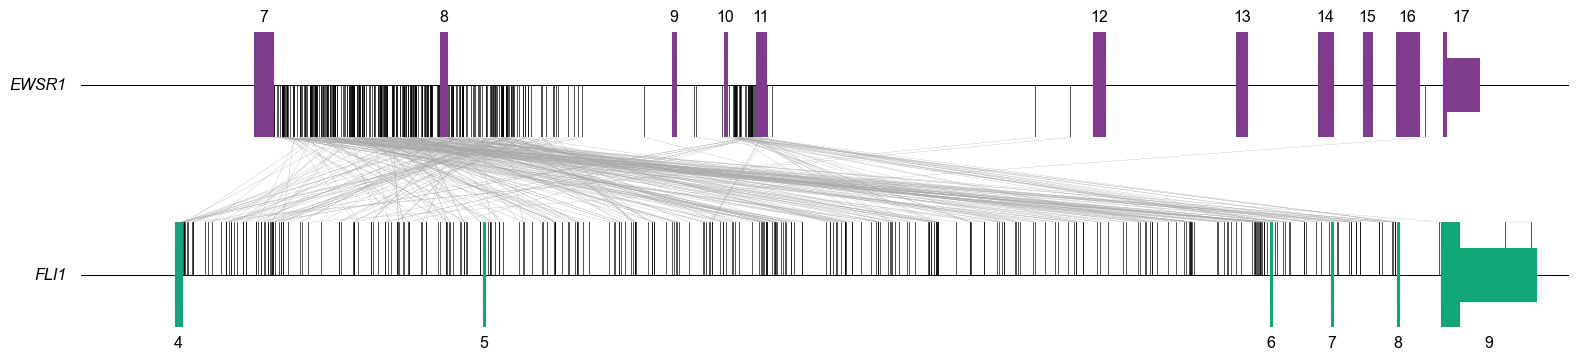

In [7]:
windows = {"EWSR1": [29285000, 29301522], "FLI1": [128770000, 128814267]}

fig, axes = plt.subplots(2, 1, figsize=(20, 4), gridspec_kw={"hspace": 0.8})

for i, g in enumerate(["EWSR1", "FLI1"]):

    ax = axes[i]
    g_gtf = gene_gtfs[g]

    # plot the genetic elements
    feature_colors = {"exon": bold_10[i], "CDS": bold_10[i]}
    label = "top" if g == "EWSR1" else "bottom"
    ax = sv_plot.plot_genomic_elements(
        ax, g_gtf, window=windows[g], feature_colors=feature_colors, label=label
    )
    aesthetics.strip_axis(ax=ax, x="label")
    ax.set_xticklabels([])
    ax.set_xlim(windows[g])

    ax.text(
        x=-0.01,
        y=0.5,
        s=g,
        fontstyle="italic",
        transform=ax.transAxes,
        ha="right",
        va="center",
    )

# next we add in the breakpoints
for index, row in fusion_bps.iterrows():
    left, right = row[["left-hg38", "right-hg38"]].values

    fig_x, fig_y = [], []
    for bp in [left, right]:
        contig, loc = bp.split(":")
        loc = int(loc)

        if contig == "22":
            ax = axes[0]
            ax.plot([loc, loc], [-1, 0], color="black", linewidth=0.5)
            data_point = [loc, -1]

        elif contig == "11":
            ax = axes[1]
            ax.plot([loc, loc], [0, 1], color="black", linewidth=0.5)
            data_point = [loc, 1]

        # exclude some fusions that are outside our range
        if (contig == "22" and loc < 29285000) or (contig == "11" and loc < 128770000):
            continue

        # get our figure point
        fig_point = fig.transFigure.inverted().transform(
            ax.transData.transform(data_point)
        )
        fig_x.append(fig_point[0])
        fig_y.append(fig_point[1])

    # add the connecting line
    fig.add_artist(Line2D(fig_x, fig_y, color="darkgrey", zorder=1, linewidth=0.2))

fig.savefig("images/ewsr1-fli1-fusion-locations.png")

So we see that there is some degree of heterogeneity, but the majority of fusions involve intronic regions between exons 7 and 8 in EWSR1 and exons 5 and 6 in FLI1. This is consistent with what's known.

# Start looking at SVs around these genes

We're essentially just going to repeat this process, just to visualize. We load both the SVs and the dosage matrix. Note that we'll use the "validation" cohort, because that increasingly looks like we'll use that for discovery.

In [9]:
svs = pd.read_csv(
    "gs://vanallen-pedsv-analysis/beds/PedSV.v2.5.2.case_control_cohort.analysis_samples.sites.bed.gz",
    sep="\t",
)

dosages = pd.read_csv(
    "gs://vanallen-pedsv-analysis/beds/PedSV.v2.5.2.case_control_cohort.analysis_samples.allele_dosages.bed.gz",
    sep="\t",
    index_col=False,
)

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (10,34,35,37,39,41,45,46,47,48,72,73,87,88,106,107,121,122,136,137,155,156,170,171,185,186,204,205,219,220,234,235,253,254,268,269,283,284,302,303,366,367,381,382,400,401,415,416,430,431,449,450,464,465,479,480,498,499,513,514,528,529,547,548,562,563,577,578,596,597,645,646,647,648,649,650,690,691,692,693,694,695,713,714,728,729,743,744,758,759,773,774,788,789,803,804,818,819,833,834,848,849,863,864,878,879,893,894,908,909,923,924,931,937,943) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [10]:
svs.head()

,#chrom,start,end,name,svtype,AC,AF,ALGORITHMS,AN,BOTHSIDES_SUPPORT,CHR2,CNV_CONCORDANCE,CPX_INTERVALS,CPX_TYPE,END,END2,EVIDENCE,FAILED_COHORT_COMPARISONS,GENOTYPE_CONCORDANCE,HET_PPV,HET_SENSITIVITY,HG38_REF_PATCH_LOCUS,HIGH_SR_BACKGROUND,HOMVAR_PPV,HOMVAR_SENSITIVITY,MINSL,NCN,NCR,NCR_TMP,NON_REF_GENOTYPE_CONCORDANCE,OLD_ID,PCRMINUS_NCR,PESR_GT_OVERDISPERSION,PREDICTED_BREAKEND_EXONIC,PREDICTED_COPY_GAIN,PREDICTED_DUP_PARTIAL,PREDICTED_INTERGENIC,PREDICTED_INTRAGENIC_EXON_DUP,PREDICTED_INTRONIC,PREDICTED_INV_SPAN,PREDICTED_LOF,PREDICTED_MSV_EXON_OVERLAP,PREDICTED_NEAREST_TSS,PREDICTED_NONCODING_BREAKPOINT,PREDICTED_NONCODING_SPAN,PREDICTED_PARTIAL_EXON_DUP,PREDICTED_PROMOTER,PREDICTED_TSS_DUP,PREDICTED_UTR,SL_MAX,...,EAS_N_HET,EAS_N_HOMALT,EAS_FREQ_HOMREF,EAS_FREQ_HET,EAS_FREQ_HOMALT,EAS_CN_NUMBER,EAS_CN_COUNT,EAS_CN_FREQ,EAS_CN_NONREF_COUNT,EAS_CN_NONREF_FREQ,SAS_AN,SAS_AC,SAS_AF,SAS_N_BI_GENOS,SAS_N_HOMREF,SAS_N_HET,SAS_N_HOMALT,SAS_FREQ_HOMREF,SAS_FREQ_HET,SAS_FREQ_HOMALT,SAS_CN_NUMBER,SAS_CN_COUNT,SAS_CN_FREQ,SAS_CN_NONREF_COUNT,SAS_CN_NONREF_FREQ,POPMAX_AF,POPMAX_FREQ_HOMREF,POPMAX_FREQ_HET,POPMAX_FREQ_HOMALT,POPMAX_CN_FREQ,POPMAX_CN_NONREF_FREQ,case_control_POPMAX_AF,case_control_POPMAX_FREQ_HOMREF,case_control_POPMAX_FREQ_HET,case_control_POPMAX_FREQ_HOMALT,case_control_POPMAX_CN_FREQ,case_control_POPMAX_CN_NONREF_FREQ,trio_POPMAX_AF,trio_POPMAX_FREQ_HOMREF,trio_POPMAX_FREQ_HET,trio_POPMAX_FREQ_HOMALT,trio_POPMAX_CN_FREQ,trio_POPMAX_CN_NONREF_FREQ,gnomad_v3.1_sv_POPMAX_AF,gnomad_v3.1_sv_POPMAX_FREQ_HOMREF,gnomad_v3.1_sv_POPMAX_FREQ_HET,gnomad_v3.1_sv_POPMAX_FREQ_HOMALT,gnomad_v3.1_sv_POPMAX_CN_FREQ,gnomad_v3.1_sv_POPMAX_CN_NONREF_FREQ,FILTER
0,chr1,12000,30001,PedSV.2.5.2_CNV_chr1_1,CNV,0,NaN,depth,0,False,NaN,NaN,NaN,NaN,30001,NaN,RD,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,0,0.000000,NaN,NaN,All_20_Batches.chr1.final_cleanup_CNV_chr1_1,NaN,False,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,OR4F5,"ewing_chromHMM15_Quies,neuroblastoma_chromHMM1...","neuroblastoma_chromHMM15_EnhG_conserved,neurob...",NaN,NaN,NaN,NaN,334.0,...,NaN,NaN,NaN,NaN,NaN,200.0,"0,0,107,65,24,3,0,1","0.0,0.0,0.5350000262260437,0.32499998807907104...",93.0,0.465,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,"0,1,28,6,2","0.0,0.02702699974179268,0.7567570209503174,0.1...",9.0,0.243243,NaN,NaN,NaN,NaN,"0.0,0.025196900591254234,0.6330710053443909,0....",NaN,NaN,NaN,NaN,NaN,"0.0,0.02552199922502041,0.6566129922866821,0.2...",NaN,NaN,NaN,NaN,NaN,"0.0,0.02450999990105629,0.659430980682373,0.30...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,MULTIALLELIC
1,chr1,12000,40001,PedSV.2.5.2_DUP_chr1_1,DUP,358,0.027564,depth,12988,False,NaN,NaN,NaN,NaN,40001,NaN,RD,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,0,0.034126,NaN,NaN,All_20_Batches.chr1.final_cleanup_DUP_chr1_1,0.006543,False,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,OR4F5,"ewing_chromHMM15_Quies,neuroblastoma_chromHMM1...","neuroblastoma_chromHMM15_EnhG_conserved,neurob...",NaN,NaN,NaN,NaN,85.0,...,11.0,3.0,0.927083,0.057292,0.015625,NaN,NaN,NaN,NaN,NaN,66.0,1.0,0.015151,33.0,32.0,1.0,0.0,0.969697,0.030303,0.000000,NaN,NaN,NaN,NaN,NaN,0.188559,0.977012,0.144068,0.116525,NaN,NaN,0.177333,0.985816,0.141333,0.106667,NaN,NaN,0.043307,0.979361,0.055118,0.015748,NaN,NaN,0.198450,NaN,NaN,NaN,NaN,NaN,PASS
2,chr1,48000,129001,PedSV.2.5.2_DUP_chr1_4,DUP,1588,0.121798,depth,13038,False,NaN,NaN,NaN,NaN,129001,NaN,RD,NaN,0.41,0.0,NaN,False,False,NaN,NaN,NaN,0,0.028367,NaN,0.0,All_20_Batches.chr1.final_cleanup_DUP_chr1_3,0.000000,False,NaN,OR4F5,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,"ewing_chromHMM15_Quies,neuroblastoma_chromHMM1...","osteosarcoma_chromHMM15_Quies,osteosarcoma_chr...",NaN,NaN,NaN,NaN,19.0,...,117.0,44.0,0.165803,0.606218,0.227979,NaN,NaN,NaN,NaN,NaN,66.0,16.0,0.242424,33.0,18.0,14.0,1.0,0.545455,0.424242,0.030303,NaN,NaN,NaN,NaN,NaN,0.531088,0.839231,0.606218,0.227979,NaN,NaN,0.334646,0.835810,0.291339,0.188976,NaN,NaN,0.539062,0.842718,0.625000,0.226563,NaN,NaN,0.706754,NaN,NaN,NaN,NaN,NaN,PASS
3,chr1,51100,100001,PedSV.2.5.2_CNV_ch

We now get our sample level data. For this analysis, we focus on Ewing's and the Ewing's controls.

In [11]:
metadata = pd.read_csv(
    "gs://vanallen-pedsv-analysis/sample_info/PedSV.v2.5.2.cohort_metadata.w_control_assignments.tsv.gz",
    sep="\t",
)

case_control_samples = pd.read_csv(
    "gs://vanallen-pedsv-analysis/sample_info/PedSV.v2.5.2.case_control_analysis_cohort.samples.list",
    header=None,
)[0].to_list()

# extract out the samples prsent in the dosage matrix
ewings_samples = metadata[(metadata["disease"] == "ewing") & (metadata['study_phase'] == 'case_control') & (metadata[f"ewing_case"])]["entity:sample_id"].to_list()
ewings_samples = sorted(set(case_control_samples) & set(ewings_samples))

control_samples = metadata[(metadata["ewing_control"]) & (metadata['disease'] == 'control') & (metadata['study_phase'] == 'case_control')]["entity:sample_id"].to_list()
control_samples = sorted(set(case_control_samples) & set(control_samples))

# create a new sex column for modeling, XY = 1
metadata["sex"] = (metadata["chrX_CopyNumber"].round() < 2).astype(int)

print(len(ewings_samples), len(control_samples))

# make sure there's no overlap between cases and controls
len(set(ewings_samples) & set(control_samples))

590 2012


0

In [12]:
metadata['disease'].value_counts()

control          6937
neuroblastoma    1806
ewing            1453
osteosarcoma      394
Name: disease, dtype: int64

And we subset the dosages to just these samples:

In [13]:
dosages = dosages[['#chr', 'start', 'end', 'ID'] + ewings_samples + control_samples]

We also remove all SVs that have no counts in genotyped samples. We don't care about these.

In [14]:
# identify the counts of each SV
sv_counts = dosages.iloc[:, 4:].fillna(0).sum(axis = 1)

# subset down SVs and dosages
svs = svs[sv_counts != 0]
dosages = dosages[sv_counts != 0]

In [15]:
svs.shape, dosages.shape

((131619, 952), (131619, 2606))

We begin by identifying structural variants that fall within our regions of interest. We only include SVs that pass quality filters (for now). We expand our search space to 1 Mb outside of these genes.

There are some small peculiarities that we should consider. Namely:
* SVs that span a region are included if any part of there region is 1 Mb away
* Complex SVs are included if any component SV is in the region


In [16]:
# get 0.5 Mb on either side of the gene
window_size = 1e6

# expand the gene "locations" to include this window
expanded_gene_locs = gene_locs.copy()
expanded_gene_locs["start"] = (expanded_gene_locs["start"] - window_size / 2).astype(
    int
)
expanded_gene_locs["end"] = (expanded_gene_locs["end"] + window_size / 2).astype(int)

# do the intersection with pybedtools. pybedtools requires either a temp file or
# a string, and we choose the latter.
expanded_gene_bed = pybedtools.BedTool(
    expanded_gene_locs.to_csv(sep="\t", index=False, header=False), from_string=True
)
sv_bed = pybedtools.BedTool(
    svs[["#chrom", "start", "end", "name"]].to_csv(sep="\t", index=False, header=False),
    from_string=True,
)

svs_in_regions = sv_bed.intersect(expanded_gene_bed, wo=True)
svs_in_regions = svs_in_regions.to_dataframe()

# drop unnecessary columns
svs_in_regions = svs_in_regions.iloc[:, [0, 1, 2, 3, 7]].copy()
svs_in_regions.columns = ["chrom", "start", "end", "name", "gene"]

In [17]:
svs_in_regions.head(2)

,chrom,start,end,name,gene
0,chr11,128214384,128216760,PedSV.2.5.2_DEL_chr11_9458,FLI1
1,chr11,128214734,128214799,PedSV.2.5.2_DEL_chr11_9459,FLI1


In [18]:
svs_in_regions.shape

(107, 5)

So it looks like there's a handful of SVs in this region. But this was only based on `Start` and `End`. There are complex SVs that may involve more. 

Most complex SVs would have already been caught above, as most are intrachromosomal and handled nicely by GATK. This code is only for theoretical interchromosomal events, but I cover them for completeness.

In [19]:
# get all complex SVs
complex_svs = svs[(svs["svtype"] == "CPX")][
    [
        "name",
        "#chrom",
        "start",
        "end",
        "svtype",
        "CHR2",
        "CPX_INTERVALS",
        "CPX_TYPE",
        "END",
    ]
].copy()

# split each component SV--represented by CPX_INTERVALS--into their own rows
complex_svs = complex_svs.assign(
    intervals=complex_svs["CPX_INTERVALS"].str.split(",")
).explode("intervals")

# convert this data to a proper bed for intersection
complex_sv_bed = complex_svs[["name", "intervals"]].copy()
complex_sv_bed["chrom"] = complex_sv_bed["intervals"].apply(
    lambda interv: interv.split(":")[0].split("_")[-1]
)
complex_sv_bed["start"] = complex_sv_bed["intervals"].apply(
    lambda interv: interv.split(":")[-1].split("-")[0]
)
complex_sv_bed["end"] = complex_sv_bed["intervals"].apply(
    lambda interv: interv.split(":")[-1].split("-")[1]
)

# convert to a bedtool
complex_sv_bed = pybedtools.BedTool(
    complex_sv_bed[["chrom", "start", "end", "name"]].to_csv(
        sep="\t", index=False, header=False
    ),
    from_string=True,
)

# do our intersection
complex_svs_in_regions = complex_sv_bed.intersect(expanded_gene_bed, wo=True)

complex_svs_in_regions = complex_svs_in_regions.to_dataframe()

# drop unnecessary columns
if len(complex_svs_in_regions):
    complex_svs_in_regions = complex_svs_in_regions.iloc[:, [0, 1, 2, 3, 7]].copy()
    complex_svs_in_regions.columns = ["chrom", "start", "end", "name", "gene"]
else:
    complex_svs_in_regions = pd.DataFrame(
        columns=["chrom", "start", "end", "name", "gene"]
    )

In [20]:
complex_svs_in_regions

,chrom,start,end,name,gene
0,chr22,29729402,29729577,PedSV.2.5.2_CPX_chr5_70,EWSR1
1,chr11,129143073,129143620,PedSV.2.5.2_CPX_chr11_267,FLI1


In [21]:
# the number of complex SVs recovered, and the number that were in our original simple overlap
len(set(complex_svs_in_regions["name"])), len(
    set(complex_svs_in_regions["name"]) & set(svs_in_regions["name"])
)

(2, 1)

So looks like 1 SV was missed in our initial simple overlap. It's pretty obvious why this is the case:

In [22]:
svs[svs["name"].isin(complex_svs_in_regions["name"])].head(2)

,#chrom,start,end,name,svtype,AC,AF,ALGORITHMS,AN,BOTHSIDES_SUPPORT,CHR2,CNV_CONCORDANCE,CPX_INTERVALS,CPX_TYPE,END,END2,EVIDENCE,FAILED_COHORT_COMPARISONS,GENOTYPE_CONCORDANCE,HET_PPV,HET_SENSITIVITY,HG38_REF_PATCH_LOCUS,HIGH_SR_BACKGROUND,HOMVAR_PPV,HOMVAR_SENSITIVITY,MINSL,NCN,NCR,NCR_TMP,NON_REF_GENOTYPE_CONCORDANCE,OLD_ID,PCRMINUS_NCR,PESR_GT_OVERDISPERSION,PREDICTED_BREAKEND_EXONIC,PREDICTED_COPY_GAIN,PREDICTED_DUP_PARTIAL,PREDICTED_INTERGENIC,PREDICTED_INTRAGENIC_EXON_DUP,PREDICTED_INTRONIC,PREDICTED_INV_SPAN,PREDICTED_LOF,PREDICTED_MSV_EXON_OVERLAP,PREDICTED_NEAREST_TSS,PREDICTED_NONCODING_BREAKPOINT,PREDICTED_NONCODING_SPAN,PREDICTED_PARTIAL_EXON_DUP,PREDICTED_PROMOTER,PREDICTED_TSS_DUP,PREDICTED_UTR,SL_MAX,...,EAS_N_HET,EAS_N_HOMALT,EAS_FREQ_HOMREF,EAS_FREQ_HET,EAS_FREQ_HOMALT,EAS_CN_NUMBER,EAS_CN_COUNT,EAS_CN_FREQ,EAS_CN_NONREF_COUNT,EAS_CN_NONREF_FREQ,SAS_AN,SAS_AC,SAS_AF,SAS_N_BI_GENOS,SAS_N_HOMREF,SAS_N_HET,SAS_N_HOMALT,SAS_FREQ_HOMREF,SAS_FREQ_HET,SAS_FREQ_HOMALT,SAS_CN_NUMBER,SAS_CN_COUNT,SAS_CN_FREQ,SAS_CN_NONREF_COUNT,SAS_CN_NONREF_FREQ,POPMAX_AF,POPMAX_FREQ_HOMREF,POPMAX_FREQ_HET,POPMAX_FREQ_HOMALT,POPMAX_CN_FREQ,POPMAX_CN_NONREF_FREQ,case_control_POPMAX_AF,case_control_POPMAX_FREQ_HOMREF,case_control_POPMAX_FREQ_HET,case_control_POPMAX_FREQ_HOMALT,case_control_POPMAX_CN_FREQ,case_control_POPMAX_CN_NONREF_FREQ,trio_POPMAX_AF,trio_POPMAX_FREQ_HOMREF,trio_POPMAX_FREQ_HET,trio_POPMAX_FREQ_HOMALT,trio_POPMAX_CN_FREQ,trio_POPMAX_CN_NONREF_FREQ,gnomad_v3.1_sv_POPMAX_AF,gnomad_v3.1_sv_POPMAX_FREQ_HOMREF,gnomad_v3.1_sv_POPMAX_FREQ_HET,gnomad_v3.1_sv_POPMAX_FREQ_HOMALT,gnomad_v3.1_sv_POPMAX_CN_FREQ,gnomad_v3.1_sv_POPMAX_CN_NONREF_FREQ,FILTER
49831,chr5,31244570,31244571,PedSV.2.5.2_CPX_chr5_70,CPX,13,0.000966,manta,13462,True,chr22,NaN,DUP_chr22:29729402-29729577,dDUP,31244571,29729402.0,"PE,SR",NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,0,0.0,NaN,NaN,All_20_Batches.chr5.final_cleanup_CPX_chr5_121,0.0,False,NaN,NaN,NaN,False,CABP7,CDH6,NaN,NaN,NaN,NaN,"ewing_chromHMM15_Quies,neuroblastoma_chromHMM1...",NaN,NaN,NaN,NaN,NaN,119.0,...,0.0,0.0,1.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,74.0,0.0,0.000000,37.0,37.0,0.0,0.0,1.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.012121,1.000000,0.016162,0.004040,NaN,NaN,0.010283,1.000000,0.015424,0.002571,NaN,NaN,0.018868,1.000000,0.018868,0.009434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PASS
108201,chr11,129145382,129145383,PedSV.2.5.2_CPX_chr11_267,CPX,1877,0.139430,"manta,wham",13462,True,chr11,NaN,DUP_chr11:129143073-129143620,dDUP,129145383,129143073.0,"PE,SR",NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,0,0.0,NaN,NaN,All_20_Batches.chr11.final_cleanup_CPX_chr11_452,0.0,False,NaN,NaN,NaN,False,NaN,ARHGAP32,NaN,NaN,NaN,NaN,"ewing_ABC_MAX_enhancer_unconserved,ewing_and_o...",NaN,NaN,NaN,NaN,NaN,122.0,...,38.0,6.0,0.78,0.19,0.03,NaN,NaN,NaN,NaN,NaN,74.0,7.0,0.094595,37.0,31.0,5.0,1.0,0.837838,0.135135,0.027027,NaN,NaN,NaN,NaN,NaN,0.149795,0.854545,0.228001,0.035794,NaN,NaN,0.151746,0.845758,0.242571,0.030461,NaN,NaN,0.147829,0.886792,0.213323,0.046154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PASS


We can see why this was missed - it's a dispersed duplication where a region of chromosome 5 (?) was inserted into a region of chromosome 22.

In any case, we can now generate a (preliminary) list of SVs that are within 1 Mb of EWSR1 or FLI1.

## Subsetting and QC'ing SVs in gene regions

To save memory, we subset the big SV and dosage matrices down to just these samples and SVs.

In [23]:
# keep the gene names
svs_in_regions_names = pd.concat(
    [svs_in_regions[["name", "gene"]], complex_svs_in_regions[["name", "gene"]]]
)

# drop duplicates (only happens if an SV is simple but part of a complex SV)
svs_in_regions_names = svs_in_regions_names.drop_duplicates(subset = ['name'])

In [24]:
len(svs_in_regions_names)

108

So a decent number of SVs in this dataset fall within this region. Briefly, Ryan and Riaz wanted to know if there are any MCNVs


In [25]:
svs[svs['name'].isin(svs_in_regions_names['name'])]['svtype'].value_counts()

DEL             50
INS:ME:ALU      24
DUP             19
INS              7
INS:ME:LINE1     3
CPX              2
INS:ME:SVA       2
CTX              1
Name: svtype, dtype: int64

So no. We fetch all these SVs from the original dataset now and apply some filters:

In [26]:
# subset
subset_svs = svs.set_index("name").loc[svs_in_regions_names["name"]].reset_index()
subset_svs.insert(0, "gene", svs_in_regions_names["gene"].values)

# convert AF to float. Only works because no CNVs (which have AF = "None")
subset_svs['AF'] = subset_svs['AF'].astype(float)

# how many are PASS?
print(subset_svs["FILTER"].value_counts())

# and how many are rare?
print("\nRare:\n", (subset_svs["AF"] < 0.01).value_counts())

PASS    108
Name: FILTER, dtype: int64

Rare:
 True     94
False    14
Name: AF, dtype: int64


That's not bad. How many pass the filter, are rare, and are present in the dosage matrix?

We'll add in a quick QC method to remove some suspect SVs that Ryan is concerned about.

In [27]:
# only include SVs that pass the FILTER, are rare, and are in our dosage matrix
svs_to_keep = subset_svs[
    (
        (subset_svs["FILTER"] == "PASS")
        & (subset_svs["name"].isin(dosages["ID"].to_list()))
    )
].copy()

svs_to_keep["rare"] = svs_to_keep["AF"] < 0.01

svs_to_keep.shape

(108, 954)

In [28]:
svs_to_keep["svtype"].value_counts()

DEL             50
INS:ME:ALU      24
DUP             19
INS              7
INS:ME:LINE1     3
CPX              2
INS:ME:SVA       2
CTX              1
Name: svtype, dtype: int64

Text(0.5, 0, 'AF')

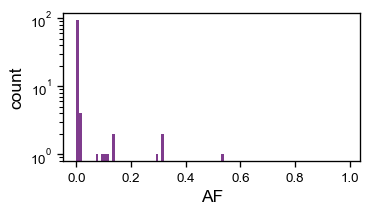

In [29]:
fig, ax = plt.subplots(1, figsize=(4, 2))
plt.hist(svs_to_keep["AF"], bins=np.arange(0, 1, 0.01))
plt.yscale("log")
plt.ylabel("count")
plt.xlabel("AF")

So there are some SVs in this region, and the vast majority are rare (unsurprisingly). We'll analyze them all together, but at some points keep rare separate.

In [30]:
(svs_to_keep["AF"] < 0.01).value_counts()

True     94
False    14
Name: AF, dtype: int64

In [31]:
svs_to_keep['HG38_REF_PATCH_LOCUS'].sum()

0

## Extract sample dosages

Here we pull out the allele counts for each SV, so that we can determine case vs. control.

In [32]:
# we begin by subsetting the dosage matrix down to the SVs that we care about. This double counts SVs
# that affect more than one gene.
subset_dosages = dosages[dosages["ID"].isin(svs_to_keep["name"].to_list())].reset_index(
    drop=True
)

# we add in the information about which gene is affected (the first column is just the SV name, so we drop it)
subsetted_gene_dosages = (
    svs_to_keep[["name", "gene", "AF", "rare"]]
    .merge(subset_dosages, right_on="ID", left_on="name")
    .iloc[1:]
)

subsetted_gene_dosages.head(2)

,name,gene,AF,rare,#chr,start,end,ID,PT_01DFN5RM,PT_01M9PKK3,PT_035W09DD,PT_04DNDVQ4,PT_04JFGZG0,PT_06E5K01A,PT_077HFD5H,PT_08Q67EXR,PT_0AQBKJ41,PT_0B57G8G3,PT_0BNTBQ7Q,PT_0CPPWCBM,PT_0FZKC12F,PT_0GVTWP1T,PT_0GWCW52B,PT_0H92PE8S,PT_0K36PA08,PT_0MW89PH3,PT_0N3XTPFC,PT_0PCC8H90,PT_0RFAAQR8,PT_0SRVYEJJ,PT_0TTCSEGS,PT_0X089RCD,PT_0X6PA6JW,PT_0YQ707Q5,PT_154SQQR4,PT_183PSR24,PT_1CZCXZKH,PT_1DREVMJY,PT_1HGPX8WD,PT_1JBR9HP2,PT_1JYPH1DC,PT_1N4DT7CC,PT_1NDK2HPT,PT_1PVZQHRV,PT_1QGFS9Q2,PT_1SF34HY2,PT_1V935759,PT_1VK7SR3P,PT_1WGNV1S3,PT_201GCSSG,...,ssi_14725,ssi_14730,ssi_14734,ssi_14740,ssi_14744,ssi_14745,ssi_14751,ssi_14752,ssi_14755,ssi_14758,ssi_14759,ssi_14760,ssi_14763,ssi_24815,ssi_24825,ssi_24852,ssi_24871,ssi_24925,ssi_24944,ssi_24952,ssi_25032,ssi_25152,ssi_25186,ssi_25255,ssi_25262,ssi_25319,ssi_25328,ssi_25337,ssi_25467,ssi_25491,ssi_25509,ssi_25540,ssi_25542,ssi_25586,ssi_25615,ssi_25639,ssi_25663,ssi_25690,ssi_25716,ssi_25726,ssi_25815,ssi_25837,ssi_25849,ssi_25985,ssi_26055,ssi_26060,ssi_26301,ssi_26305,ssi_26369,ssi_26393
1,PedSV.2.5.2_DEL_chr11_9459,FLI1,0.002006,True,chr11,128214735,128214799,PedSV.2.5.2_DEL_chr11_9459,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,PedSV.2.5.2_DUP_chr11_2453,FLI1,0.312955,False,chr11,128226922,128226985,PedSV.2.5.2_DUP_chr11_2453,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,2.0,...,1.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0


Next, we devise two metrics for cases and controls--one listing the allele frequency of each SV and another listing the number of samples with an SV in the gene.

We need to convert the dosage (allele count) to allele frequencies

In [33]:
case_control_counts = []
case_control_samples_with_svs = []

for sample_group, label in zip(
    [ewings_samples, control_samples], ["cases", "controls"]
):

    # subset to these samples
    sample_dosages = subsetted_gene_dosages[
        ["name", "gene", "#chr", "start", "end", "AF", "rare"] + sample_group
    ]

    # first, count the SVs. This function counts the number of samples with each genotype.
    sv_counts = (
        sample_dosages[sample_group]
        .apply(lambda row: row.dropna().value_counts(), axis=1)
        .fillna(0)
        .astype(int)
    )

    # name columns to genotypes
    sv_counts.columns = f"{label}_" + sv_counts.columns.astype(int).astype(str)
    sv_counts["name"] = sample_dosages["name"]

    case_control_counts.append(sv_counts)

    # now count the number of samples with at least one SV around each gene.
    # we groupby gene, then determine whether each sample has an SV in that gene, then
    # count these samples up per gene.
    num_samples_with_svs = sample_dosages.groupby(["gene"]).apply(
        lambda group: (group[sample_group] > 0).any(axis=0).sum()
    )
    
    num_samples_with_svs.name = label + "_all"
    num_samples_with_svs = num_samples_with_svs / len(sample_group)
    case_control_samples_with_svs.append(num_samples_with_svs)
    
    # repeat for rare SVs
    num_samples_with_svs_rare = (
        sample_dosages.query("rare == True")
        .groupby(["gene"])
        .apply(lambda group: (group[sample_group] > 0).any(axis=0).sum())
    )

    num_samples_with_svs_rare.name = label + "_rare"
    num_samples_with_svs_rare = num_samples_with_svs_rare / len(sample_group)
    case_control_samples_with_svs.append(num_samples_with_svs_rare)

# merge
case_control_sv_counts = sample_dosages.iloc[:, :7].reset_index(drop=True)
for df in case_control_counts:
    case_control_sv_counts = case_control_sv_counts.merge(df)

case_control_sv_counts["midpoint"] = np.mean(
    case_control_sv_counts[["start", "end"]], axis=1
)

# and total up the sample counts
case_control_sample_counts = pd.DataFrame(case_control_samples_with_svs).T

In [34]:
case_control_sv_counts.head(2)

,name,gene,#chr,start,end,AF,rare,cases_0,cases_1,cases_2,controls_0,controls_1,controls_2,midpoint
0,PedSV.2.5.2_DEL_chr11_9459,FLI1,chr11,128214735,128214799,0.002006,True,589,1,0,2009,3,0,128214767.0
1,PedSV.2.5.2_DUP_chr11_2453,FLI1,chr11,128226922,128226985,0.312955,False,244,300,46,894,968,150,128226953.5


Next we add some columns for allele frequency.

In [35]:
for label in ["cases", "controls"]:

    # a quick check to see if there are non-0/1/2 genotypes
    columns = [col for col in case_control_sv_counts.columns if col.startswith(label)]
    assert columns == [f"{label}_{i}" for i in range(3)]

    alt = (case_control_sv_counts[columns] * np.array([0, 1, 2])).sum(axis=1)
    ref = case_control_sv_counts[columns].sum(axis=1) * 2
    case_control_sv_counts[f"AF_{label}"] = alt / ref

In [36]:
case_control_sv_counts.head(2)

,name,gene,#chr,start,end,AF,rare,cases_0,cases_1,cases_2,controls_0,controls_1,controls_2,midpoint,AF_cases,AF_controls
0,PedSV.2.5.2_DEL_chr11_9459,FLI1,chr11,128214735,128214799,0.002006,True,589,1,0,2009,3,0,128214767.0,0.000847,0.000746
1,PedSV.2.5.2_DUP_chr11_2453,FLI1,chr11,128226922,128226985,0.312955,False,244,300,46,894,968,150,128226953.5,0.332203,0.315109


In [37]:
case_control_sample_counts

,cases_all,cases_rare,controls_all,controls_rare
gene,,,,
EWSR1,1.000000,0.032203,1.000000,0.044732
FLI1,0.905085,0.052542,0.904573,0.052187


Any smoking guns in terms of SVs?

In [38]:
freq_diff = case_control_sv_counts["AF_cases"] - (case_control_sv_counts["AF_controls"])

case_control_sv_counts.iloc[freq_diff.sort_values(ascending=False).index].query('rare == True').head(10)

,name,gene,#chr,start,end,AF,rare,cases_0,cases_1,cases_2,controls_0,controls_1,controls_2,midpoint,AF_cases,AF_controls
3,PedSV.2.5.2_INS_chr11_3724,FLI1,chr11,128274149,128274149,0.006990,True,571,13,0,1966,34,0,128274149.0,0.011130,0.008500
76,PedSV.2.5.2_DEL_chr22_1516,EWSR1,chr22,29283448,29285955,0.007280,True,585,5,0,2002,10,0,29284701.5,0.004237,0.002485
30,PedSV.2.5.2_DEL_chr11_9501,FLI1,chr11,128926202,128927178,0.000371,True,588,2,0,2011,1,0,128926690.0,0.001695,0.000249
32,PedSV.2.5.2_DEL_chr11_9507,FLI1,chr11,128961094,128964897,0.001634,True,587,3,0,2006,6,0,128962995.5,0.002542,0.001491
57,PedSV.2.5.2_INS_chr22_343,EWSR1,chr22,28846483,28846483,0.000074,True,587,1,0,2012,0,0,28846483.0,0.000850,0.000000
60,PedSV.2.5.2_INS_chr22_347,EWSR1,chr22,28885642,28885642,0.000149,True,589,1,0,2012,0,0,28885642.0,0.000847,0.000000
2,PedSV.2.5.2_INS_chr11_3723,FLI1,chr11,128271218,128271218,0.000223,True,589,1,0,2011,0,0,128271218.0,0.000847,0.000000
21,PedSV.2.5.2_DEL_chr11_9480,FLI1,chr11,128650835,128654105,0.000074,True,589,1,0,2012,0,0,128652470.0,0.000847,0.000000
83,PedSV.2.5.2_DUP_chr22_451,EWSR1,chr22,29449662,29449752,0.000074,True,589,1,0,2012,0,0,29449707.0,0.000847,0.000000
90,PedSV.2.5.2_DUP_chr22_456,EWSR1,chr22,29573598,29574608,0.000074,True,589,1,0,2012,0,0,29574103.0,0.000847,0.000000


In [39]:
case_control_sv_counts.iloc[freq_diff.sort_values(ascending=False).index].tail(4)

,name,gene,#chr,start,end,AF,rare,cases_0,cases_1,cases_2,controls_0,controls_1,controls_2,midpoint,AF_cases,AF_controls
13,PedSV.2.5.2_INS_chr11_3729,FLI1,chr11,128497937,128497937,0.010716,False,586,3,1,1962,46,0,128497937.0,0.004237,0.011454
36,PedSV.2.5.2_INS_chr11_3738,FLI1,chr11,129046369,129046369,0.015702,False,582,6,0,1952,55,0,129046369.0,0.005102,0.013702
75,PedSV.2.5.2_DEL_chr22_1513,EWSR1,chr22,29237100,29239401,0.105036,False,494,87,9,1674,281,57,29238250.5,0.088983,0.098161
81,PedSV.2.5.2_DUP_chr22_449,EWSR1,chr22,29410573,29410660,0.131853,False,460,130,0,1398,614,0,29410616.5,0.110169,0.152584


I find that somewhat surprising... there are several instances where the number of SVs in a gene is different between cases and controls, but it seems to favor the controls. What could be the reason for this, ancestry? Artifact?

## Where do these fall relative to gene regions?

Presumably, the closer they are to the gene, the more we expect them to matter. We'll just map them out on the gene locuses (I like to visualize first).

This is a little hamfisted, but we'll split by common SVs and then just rare.

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator


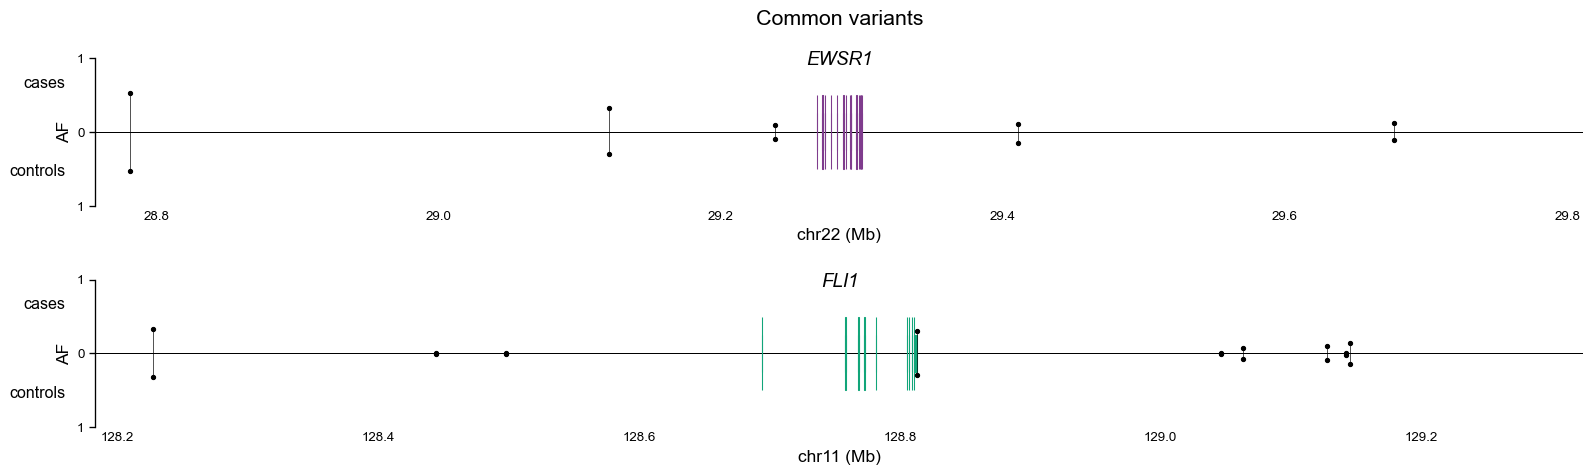

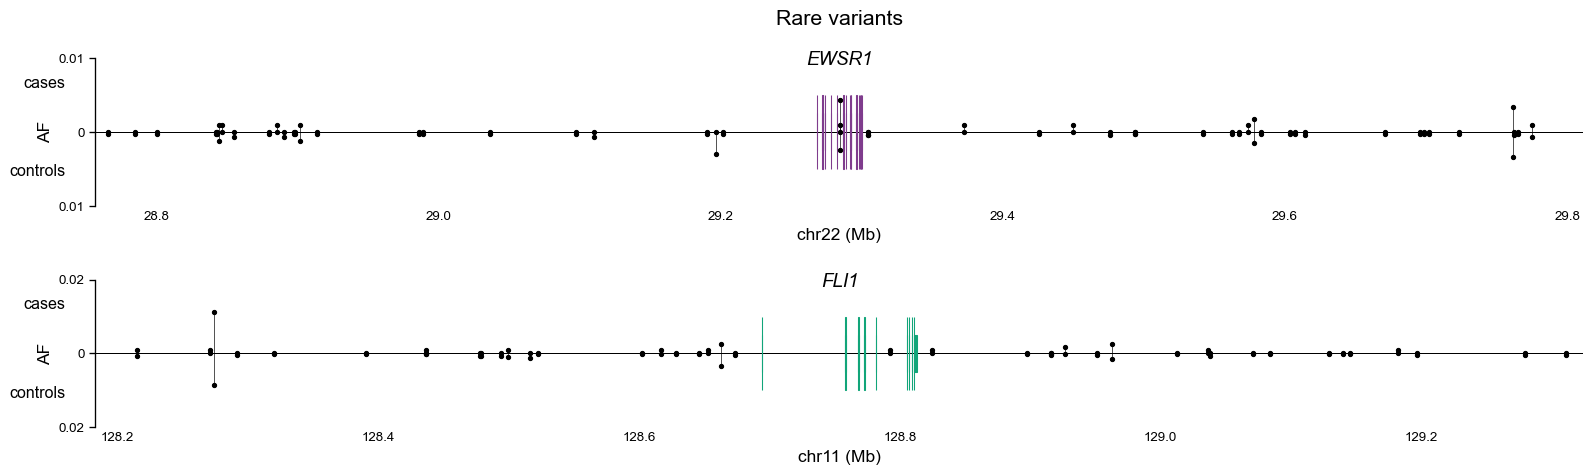

In [40]:
for plot in ["common", "rare"]:

    fig, axes = plt.subplots(
        len(expanded_gene_locs),
        1,
        figsize=(20, 2.5 * len(expanded_gene_locs)),
        gridspec_kw={"hspace": 0.5},
    )

    for i, g in enumerate(expanded_gene_locs["gene"]):

        ax = axes[i]
        g_gtf = gene_gtfs[g]

        # plot the genetic elements
        feature_colors = {"exon": bold_10[i], "CDS": bold_10[i]}
        window = expanded_gene_locs.loc[g, ["start", "end"]].values
        feature_span = {"exon": 0.25, "CDS": 0.5}

        ax = sv_plot.plot_genomic_elements(
            ax,
            g_gtf,
            window=window,
            feature_span=feature_span,
            feature_colors=feature_colors,
            label=False,
        )
        aesthetics.strip_axis(ax=ax, x="label", y="ignore")

        contig = expanded_gene_locs.loc[g, "chrom"]
        ax.set_title(g, fontstyle="italic", y=0.9)

        # plot the range of interest
        ax.set_xlim(
            expanded_gene_locs.loc[g, ["start", "end"]].values
            + np.array([-10000, 10000])
        )
        ax.spines["bottom"].set_bounds(
            expanded_gene_locs.loc[g, ["start", "end"]].values
        )

        # add labels
        ax.text(s="cases", x=-0.02, y=0.8, transform=ax.transAxes, ha="right")
        ax.text(s="controls", x=-0.02, y=0.2, transform=ax.transAxes, ha="right")

        # switch to Mb
        ax.set_xticklabels(ax.get_xticks() / 1e6)
        ax.set_xlabel(f"{contig} (Mb)")

    # next we add in the SVs. First subset to the SVs in question
    if plot == "common":
        plot_svs = case_control_sv_counts.query("rare == False").copy()
    elif plot == "rare":
        plot_svs = case_control_sv_counts.query("rare == True").copy()

    for i, gene in enumerate(expanded_gene_locs["gene"]):

        ax = axes[i]
        gene_data = plot_svs[plot_svs["gene"] == gene]

        # get the max frequency
        max_freq = gene_data[["AF_cases", "AF_controls"]].max().max()

        if plot == "common":
            rounded_max = 1
        if plot == "rare":
            rounded_max = math.ceil(max_freq * 100) / 100

        # its much easier to plot everything at once with plt.stem, but that function sucks
        # we scale the frequency to fill the plot
        case_y = (gene_data["AF_cases"]) / rounded_max
        control_y = (gene_data["AF_controls"]) / rounded_max

        # add the points
        ax.scatter(x=gene_data["midpoint"], y=case_y, color="black", s=10, zorder=3)
        ax.scatter(x=gene_data["midpoint"], y=-control_y, color="black", s=10, zorder=3)

        # add the lollipop lines
        for loc, case, control in zip(gene_data["midpoint"], case_y, control_y):
            ax.plot(
                [loc, loc],
                [case, -control],
                color="black",
                linewidth=0.5,
                zorder=3,
            )

        ax.set_yticks([-1, 0, 1])
        ax.set_yticklabels([rounded_max, 0, rounded_max])
        ax.set_ylabel("AF")

    # add a title - can't use suptitle because that doesn't center over the gene
    axes[0].text(
        s=plot.capitalize() + " variants",
        x=0.5,
        y=1.2,
        transform=axes[0].transAxes,
        ha="center",
        va="bottom",
        fontsize=16,
    )

    # fig.savefig(f"images/{plot}-ewsr1-fli1-discovery-sv-locations.png")

# Some quick observations

I think they'll probably amount to nothing, but I wanted to note two small things:

There are SVs very close and within EWSR1 and FLI1. None are significantly different between cases and controls, but worth mentioning.

In [41]:
case_control_sv_counts[
    (case_control_sv_counts["gene"] == "EWSR1")
    & (
        case_control_sv_counts["midpoint"].between(
            gene_locs.loc["EWSR1", "start"], gene_locs.loc["EWSR1", "end"]
        )
    )
]

,name,gene,#chr,start,end,AF,rare,cases_0,cases_1,cases_2,controls_0,controls_1,controls_2,midpoint,AF_cases,AF_controls
76,PedSV.2.5.2_DEL_chr22_1516,EWSR1,chr22,29283448,29285955,0.007280,True,585,5,0,2002,10,0,29284701.5,0.004237,0.002485
77,PedSV.2.5.2_DUP_chr22_444,EWSR1,chr22,29284244,29285107,0.000074,True,589,1,0,2011,0,0,29284675.5,0.000847,0.000000


One of these is a 2kb deletion in between exons 5 and 6 of EWSR1, with a reasonable number of cases and controls. 

In [42]:
case_control_sv_counts[
    (case_control_sv_counts["gene"] == "FLI1")
    & (
        case_control_sv_counts["midpoint"].between(
            gene_locs.loc["FLI1", "start"], gene_locs.loc["FLI1", "end"]
        )
    )
]

,name,gene,#chr,start,end,AF,rare,cases_0,cases_1,cases_2,controls_0,controls_1,controls_2,midpoint,AF_cases,AF_controls
24,PedSV.2.5.2_CTX_chr11_2,FLI1,chr11,128792578,128792578,0.000074,True,589,1,0,2012,0,0,128792578.0,0.000847,0.000000
25,PedSV.2.5.2_DEL_chr11_9485,FLI1,chr11,128812821,128813515,0.291171,False,302,215,73,1039,754,218,128813168.0,0.305932,0.295873


In [44]:
svs_to_keep.query('name == "PedSV.2.5.2_DEL_chr11_9485"')

,gene,name,#chrom,start,end,svtype,AC,AF,ALGORITHMS,AN,BOTHSIDES_SUPPORT,CHR2,CNV_CONCORDANCE,CPX_INTERVALS,CPX_TYPE,END,END2,EVIDENCE,FAILED_COHORT_COMPARISONS,GENOTYPE_CONCORDANCE,HET_PPV,HET_SENSITIVITY,HG38_REF_PATCH_LOCUS,HIGH_SR_BACKGROUND,HOMVAR_PPV,HOMVAR_SENSITIVITY,MINSL,NCN,NCR,NCR_TMP,NON_REF_GENOTYPE_CONCORDANCE,OLD_ID,PCRMINUS_NCR,PESR_GT_OVERDISPERSION,PREDICTED_BREAKEND_EXONIC,PREDICTED_COPY_GAIN,PREDICTED_DUP_PARTIAL,PREDICTED_INTERGENIC,PREDICTED_INTRAGENIC_EXON_DUP,PREDICTED_INTRONIC,PREDICTED_INV_SPAN,PREDICTED_LOF,PREDICTED_MSV_EXON_OVERLAP,PREDICTED_NEAREST_TSS,PREDICTED_NONCODING_BREAKPOINT,PREDICTED_NONCODING_SPAN,PREDICTED_PARTIAL_EXON_DUP,PREDICTED_PROMOTER,PREDICTED_TSS_DUP,PREDICTED_UTR,...,EAS_N_HOMALT,EAS_FREQ_HOMREF,EAS_FREQ_HET,EAS_FREQ_HOMALT,EAS_CN_NUMBER,EAS_CN_COUNT,EAS_CN_FREQ,EAS_CN_NONREF_COUNT,EAS_CN_NONREF_FREQ,SAS_AN,SAS_AC,SAS_AF,SAS_N_BI_GENOS,SAS_N_HOMREF,SAS_N_HET,SAS_N_HOMALT,SAS_FREQ_HOMREF,SAS_FREQ_HET,SAS_FREQ_HOMALT,SAS_CN_NUMBER,SAS_CN_COUNT,SAS_CN_FREQ,SAS_CN_NONREF_COUNT,SAS_CN_NONREF_FREQ,POPMAX_AF,POPMAX_FREQ_HOMREF,POPMAX_FREQ_HET,POPMAX_FREQ_HOMALT,POPMAX_CN_FREQ,POPMAX_CN_NONREF_FREQ,case_control_POPMAX_AF,case_control_POPMAX_FREQ_HOMREF,case_control_POPMAX_FREQ_HET,case_control_POPMAX_FREQ_HOMALT,case_control_POPMAX_CN_FREQ,case_control_POPMAX_CN_NONREF_FREQ,trio_POPMAX_AF,trio_POPMAX_FREQ_HOMREF,trio_POPMAX_FREQ_HET,trio_POPMAX_FREQ_HOMALT,trio_POPMAX_CN_FREQ,trio_POPMAX_CN_NONREF_FREQ,gnomad_v3.1_sv_POPMAX_AF,gnomad_v3.1_sv_POPMAX_FREQ_HOMREF,gnomad_v3.1_sv_POPMAX_FREQ_HET,gnomad_v3.1_sv_POPMAX_FREQ_HOMALT,gnomad_v3.1_sv_POPMAX_CN_FREQ,gnomad_v3.1_sv_POPMAX_CN_NONREF_FREQ,FILTER,rare
26,FLI1,PedSV.2.5.2_DEL_chr11_9485,chr11,128812820,128813515,DEL,3918,0.291171,manta,13456,True,NaN,NaN,NaN,NaN,128813515,NaN,"PE,RD,SR",NaN,0.883,0.998,1.0,False,False,0.5,NaN,-12.0,3,0.00032,NaN,0.736,All_20_Batches.chr11.final_cleanup_DEL_chr11_1...,0.0,True,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,ewing_chromHMM15_Quies_conserved,NaN,NaN,NaN,NaN,FLI1,...,21.0,0.55,0.345,0.105,NaN,NaN,NaN,NaN,NaN,74.0,19.0,0.256757,37.0,22.0,11.0,4.0,0.594595,0.297297,0.108108,NaN,NaN,NaN,NaN,NaN,0.310052,0.761616,0.361246,0.129429,NaN,NaN,0.315868,0.77892,0.393906,0.118915,NaN,NaN,0.304193,0.698113,0.392157,0.140022,NaN,NaN,0.346811,NaN,NaN,NaN,NaN,NaN,PASS,False


There is a common SV that is a 700 bp deletion that is the 3' UTR of FLI1. It's quite common in the general population, although it does not differ between cases and controls.

The last thing that I'll note is that there is a _germline_ fusion between EWSR1 and FLI1.

In [46]:
svs_to_keep[svs_to_keep["name"] == "PedSV.2.5.2_CTX_chr11_2"]

,gene,name,#chrom,start,end,svtype,AC,AF,ALGORITHMS,AN,BOTHSIDES_SUPPORT,CHR2,CNV_CONCORDANCE,CPX_INTERVALS,CPX_TYPE,END,END2,EVIDENCE,FAILED_COHORT_COMPARISONS,GENOTYPE_CONCORDANCE,HET_PPV,HET_SENSITIVITY,HG38_REF_PATCH_LOCUS,HIGH_SR_BACKGROUND,HOMVAR_PPV,HOMVAR_SENSITIVITY,MINSL,NCN,NCR,NCR_TMP,NON_REF_GENOTYPE_CONCORDANCE,OLD_ID,PCRMINUS_NCR,PESR_GT_OVERDISPERSION,PREDICTED_BREAKEND_EXONIC,PREDICTED_COPY_GAIN,PREDICTED_DUP_PARTIAL,PREDICTED_INTERGENIC,PREDICTED_INTRAGENIC_EXON_DUP,PREDICTED_INTRONIC,PREDICTED_INV_SPAN,PREDICTED_LOF,PREDICTED_MSV_EXON_OVERLAP,PREDICTED_NEAREST_TSS,PREDICTED_NONCODING_BREAKPOINT,PREDICTED_NONCODING_SPAN,PREDICTED_PARTIAL_EXON_DUP,PREDICTED_PROMOTER,PREDICTED_TSS_DUP,PREDICTED_UTR,...,EAS_N_HOMALT,EAS_FREQ_HOMREF,EAS_FREQ_HET,EAS_FREQ_HOMALT,EAS_CN_NUMBER,EAS_CN_COUNT,EAS_CN_FREQ,EAS_CN_NONREF_COUNT,EAS_CN_NONREF_FREQ,SAS_AN,SAS_AC,SAS_AF,SAS_N_BI_GENOS,SAS_N_HOMREF,SAS_N_HET,SAS_N_HOMALT,SAS_FREQ_HOMREF,SAS_FREQ_HET,SAS_FREQ_HOMALT,SAS_CN_NUMBER,SAS_CN_COUNT,SAS_CN_FREQ,SAS_CN_NONREF_COUNT,SAS_CN_NONREF_FREQ,POPMAX_AF,POPMAX_FREQ_HOMREF,POPMAX_FREQ_HET,POPMAX_FREQ_HOMALT,POPMAX_CN_FREQ,POPMAX_CN_NONREF_FREQ,case_control_POPMAX_AF,case_control_POPMAX_FREQ_HOMREF,case_control_POPMAX_FREQ_HET,case_control_POPMAX_FREQ_HOMALT,case_control_POPMAX_CN_FREQ,case_control_POPMAX_CN_NONREF_FREQ,trio_POPMAX_AF,trio_POPMAX_FREQ_HOMREF,trio_POPMAX_FREQ_HET,trio_POPMAX_FREQ_HOMALT,trio_POPMAX_CN_FREQ,trio_POPMAX_CN_NONREF_FREQ,gnomad_v3.1_sv_POPMAX_AF,gnomad_v3.1_sv_POPMAX_FREQ_HOMREF,gnomad_v3.1_sv_POPMAX_FREQ_HET,gnomad_v3.1_sv_POPMAX_FREQ_HOMALT,gnomad_v3.1_sv_POPMAX_CN_FREQ,gnomad_v3.1_sv_POPMAX_CN_NONREF_FREQ,FILTER,rare
25,FLI1,PedSV.2.5.2_CTX_chr11_2,chr11,128792577,128792578,CTX,1,0.000074,manta,13462,True,chr22,NaN,NaN,NaN,128792578,29289440.0,"PE,SR",NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,0,0.0,NaN,NaN,All_20_Batches.chr11.final_cleanup_CTX_chr11_2,0.0,False,NaN,NaN,NaN,False,NaN,NaN,NaN,"EWSR1,FLI1",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,74.0,0.0,0.0,37.0,37.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.000093,1.0,0.000186,0.0,NaN,NaN,0.000186,1.0,0.000371,0.0,NaN,NaN,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PASS,True


Where does this fall in these two genes? For FLI1, it is between exons 5 and 6. For EWSR1, it is between exons 8 and 9.

This is in the exact same position as somatic SVs for EWSR1-FLI1. Kind of wild. I assume this could be somatic contamination? Seems difficult to reach the 50% threshold for germline. I can't find the bam to actually look at this SV, but will be good to check.

# Begin some association analyses

* We'll begin following up on some of these analyses. We'll begin by exploring two:

1. The rare SV burden between cases and controls.
2. Association testing with individual SVs.

These are pretty simple models, based strictly on logistic regression models, so I'm fine to just do this in Python. We'll reference the R scripts for which variables to include in the model

## Rare and Common SV burden between cases and controls

This is prety straightforward. Essentially, our model is as follows:

`logit(case_status) ~ count_of_rare/common_SVs + ancestry_PCs + sex`

After some discussion with Ryan, we're leaving off coverage.

Shouldn't be too hard to construct. We'll start with common first.

In [47]:
columns = [
    "entity:sample_id",
    "disease",
    "sex",
] + [col for col in metadata.columns if col in ['PC1', 'PC2', 'PC3']]

model_data = metadata[
    metadata["entity:sample_id"].isin(ewings_samples + control_samples)
][columns].set_index("entity:sample_id")

# annoying reformatting
model_data["disease"] = model_data["disease"].replace({"ewing": 1, "control": 0})

Now we determine the dosages

In [48]:
# for both ewsr1 and fli1, and for rare, common, and combined variants, we count
for gene in gene_locs["gene"]:
    for rare in [True, False, 'combined']:
        
        if rare in [True, False]:
            gene_svs = subsetted_gene_dosages[
                (subsetted_gene_dosages["rare"] == rare)
                & (subsetted_gene_dosages["gene"] == gene)
            ]
            label = 'rare ' + gene if rare else 'common ' + gene
        elif rare == "combined":
            gene_svs = subsetted_gene_dosages[
                (subsetted_gene_dosages["gene"] == gene)
            ]
            label = 'rare + common ' + gene

        sv_counts = (gene_svs[ewings_samples + control_samples] > 0).sum(axis=0)
        
        model_data.loc[sv_counts.index, label] = sv_counts

for label in ['rare', 'common', 'rare + common']:
    model_data[label + " combined"] = model_data[label + " EWSR1"] + model_data[label + " FLI1"]
    model_data[label + "_combined_one_hot"] = (
        (model_data[label + " EWSR1"] > 0) + (model_data[label + " FLI1"] > 0)
    ).astype(int)


Now we run the model

In [50]:
for gene in gene_locs["gene"].to_list() + ["combined"]:
    for svtype in ['rare', 'common', 'rare + common']:
        
        column = svtype + ' ' + gene

        # run the model
        endog = model_data["disease"]
        exog = sm.tools.add_constant(model_data[[column] + columns[2:]])

        model = sm.Logit(
            endog,
            exog,
        ).fit(disp=0)

        coeff = model.params[1]
        p = model.pvalues[1]
        print('SV burden', svtype, gene, 'coeff:', coeff, 'p:', p)

        # also try a one-hot encoding
        if gene != "combined":
            exog[column] = (model_data[column] > 0).astype(int)
        else:
            exog[column] = model_data[svtype + "_combined_one_hot"]

        try:
            one_hot_model = sm.Logit(
            endog,
            exog,
            ).fit(disp=0)
        except:
            print('Model failed')
            continue

        coeff = one_hot_model.params[1]
        p = one_hot_model.pvalues[1]
        print("SV one hot", svtype, gene, 'coeff:', coeff, 'p:', p)

SV burden rare EWSR1 coeff: -0.1655421661220008 p: 0.4870759337053753
SV one hot rare EWSR1 coeff: -0.14664257267998246 p: 0.582059527295144
SV burden common EWSR1 coeff: -0.061471317070809765 p: 0.2535418875492552
Model failed
SV burden rare + common EWSR1 coeff: -0.06696094880996009 p: 0.20244762354868662
Model failed
SV burden rare FLI1 coeff: 0.06121828261185986 p: 0.7683973980743855
SV one hot rare FLI1 coeff: 0.09193760733802184 p: 0.6663424197373081
SV burden common FLI1 coeff: -0.0045135598085899 p: 0.9271074288730377
SV one hot common FLI1 coeff: 0.01810716099698344 p: 0.9085901663457582
SV burden rare + common FLI1 coeff: -0.001056386351539476 p: 0.9824122151050574
SV one hot rare + common FLI1 coeff: -0.028628972939299193 p: 0.8588316362429919
SV burden rare combined coeff: -0.04058200142885323 p: 0.7932568293347111
SV one hot rare combined coeff: -0.0018426329653378315 p: 0.9915678416006428
SV burden common combined coeff: -0.03028009880393522 p: 0.4025298701527331
Model fa

In [52]:
import seaborn as sns

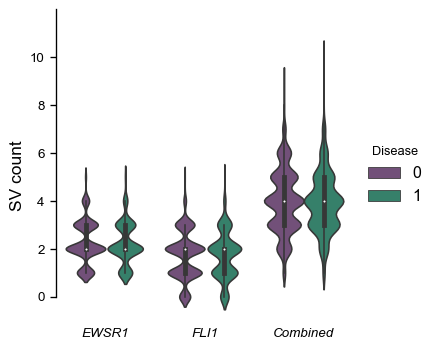

In [53]:
fig, ax = plt.subplots(1, figsize = (4,4))
melted_data = model_data.melt(id_vars = 'disease', value_vars = ['common EWSR1', 'common FLI1', 'common combined'])
sns.violinplot(x = 'variable', y = 'value', hue = 'disease', data = melted_data, saturation = 0.5, )
aesthetics.strip_axis(ax, x = 'label', y = 'ignore')
ax.set_xticklabels(['EWSR1', 'FLI1', 'Combined'], fontstyle = 'italic')
ax.spines['left'].set_bounds([0, 12])
ax.set_ylabel('SV count')
ax.set_xlabel('')
ax.legend(bbox_to_anchor = (1, 0.5), title = 'Disease')
# fig.savefig('images/ewsr1-fli1-common-sv-burden.png')

In [54]:
melted_data.groupby(['disease', 'variable'])['value'].mean()

disease  variable       
0        common EWSR1       2.270875
         common FLI1        1.707256
         common combined    3.978131
1        common EWSR1       2.220339
         common FLI1        1.715254
         common combined    3.935593
Name: value, dtype: float64

These results are somewhat interesting for the 2.5 callset. There are some significant results--namely that common SVs predispose to cases in EWSR1?

Worth keeping in mind to see if that replicates.

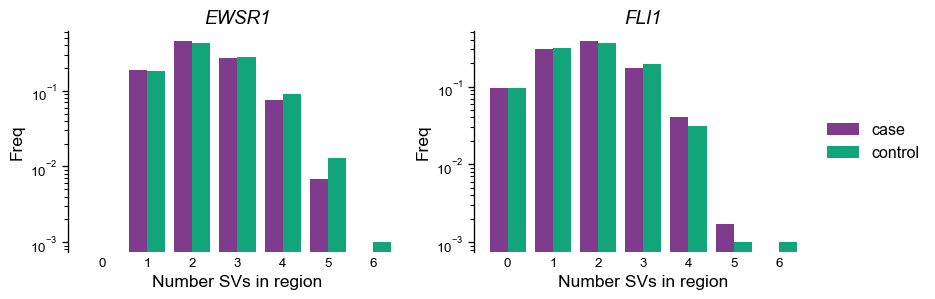

In [55]:
fig, axes = plt.subplots(1, len(gene_locs), figsize=(5 * len(gene_locs), 3))
for i, g in enumerate(gene_locs["gene"]):
    
    column = 'rare + common ' + g
    ax = axes[i]

    case_data = model_data.query("disease == 1")[column].value_counts()
    control_data = model_data.query("disease == 0")[column].value_counts()

    case_data = case_data / case_data.sum()
    control_data = control_data / control_data.sum()
    
    if 0 not in case_data.index:
        case_data.loc[0] = 0

    if 0 not in control_data.index:
        control_data.loc[0] = 0

    max_case = np.max(case_data.index)
    max_control = np.max(control_data.index)

    case_x = np.arange(0.3, max_case + 1.3, 1)
    control_x = np.arange(0.7, max_control + 1.7, 1)

    ax.bar(x=case_x, height=case_data.loc[range(max_case + 1)], width=0.4, label="case")
    ax.bar(x=control_x, height=control_data.loc[range(max_control + 1)], width=0.4, label="control")

    ax.set_yscale("log")
    aesthetics.strip_axis(ax=ax, x="label", y="ignore")

    counts = np.arange(0, np.max([max_case, max_control]) + 1)
    ax.set_xticks(counts + 0.5)
    ax.set_xticklabels(counts)

    ax.set_xlabel("Number SVs in region")
    ax.set_ylabel("Freq")
    ax.set_title(g, fontstyle="italic")

axes[-1].legend(bbox_to_anchor=(1, 0.5))
# fig.savefig('images/ewsr1-fli1-sv-burden-discovery.png')

So in fact in EWSR1 it looks like there's a small handful of controls that are different from cases.

## Individual SV analysis

Here we'll go through each SV and run a logit model, incorporating the same variables above, except time we'll use genotype.

In [56]:
columns = [
    "entity:sample_id",
    "disease",
    "sex",
] + [col for col in metadata.columns if col in ['PC1', 'PC2', 'PC3']]

model_data = metadata[
    metadata["entity:sample_id"].isin(ewings_samples + control_samples)
][columns].set_index("entity:sample_id")

# annoying reformatting
model_data["disease"] = model_data["disease"].replace({"ewing": 1, "control": 0})

Now we add the genotypes to this model data.

In [57]:
sv_dosages = subsetted_gene_dosages.set_index("name")[ewings_samples + control_samples]
model_data.loc[sv_dosages.columns, list(sv_dosages.index)] = sv_dosages.T

Next we simply loop through the SVs and run the model.

In [58]:
sv_models = {}
sv_results = []

for sv in sv_dosages.index:

    sv_model_data = model_data[columns[1:] + [sv]]

    # drop samples that could not be genotyped. This inherently introduces bias, so we keep track of the number of samples dropped.
    sv_model_data_nonna = sv_model_data.dropna(subset=[sv]).copy()
    dropped_samples = set(sv_model_data.index) - set(sv_model_data_nonna.index)
    num_cases_dropped = len(set(ewings_samples) & dropped_samples)
    num_controls_dropped = len(set(control_samples) & dropped_samples)

    # run the model
    endog = sv_model_data_nonna["disease"]
    exog = sm.tools.add_constant(sv_model_data_nonna[[sv] + columns[2:]])

    # suppress some failure warnings, which usually occur when we have few counts
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = sm.Logit(
            endog=endog,
            exog=exog,
        ).fit(disp=0, method="bfgs", maxiter=1000)

    # store
    sv_models[sv] = model
    sv_results.append(
        [
            sv,
            model.pvalues[1],
            model.params[1],
            num_cases_dropped,
            num_controls_dropped,
        ]
    )

sv_results = pd.DataFrame(
    sv_results,
    columns=["name", "p", "coeff", "num_cases_dropped", "num_controls_dropped"],
).set_index("name")

In case SVs don't have any counts in the cases and only one count in the controls, which means that colinearity exists with the covariates:

In [59]:
sv_results[pd.isnull(sv_results['p'])]

,p,coeff,num_cases_dropped,num_controls_dropped
name,,,,
PedSV.2.5.2_DEL_chr11_9470,NaN,-37.190478,0,2
PedSV.2.5.2_INS_chr11_3728,NaN,-36.254581,0,0
PedSV.2.5.2_INS_chr11_3735,NaN,-32.822896,0,0
PedSV.2.5.2_INS_chr22_355,NaN,-37.515683,0,0


We drop these

In [60]:
sv_results = sv_results[~pd.isnull(sv_results['p'])]

We also perform multiple test corrections here, using the bonferroni. We use the bonferroni because we don't have that many hypotheses.

In [61]:
sv_results['p_bonferroni'] = statsmodels.stats.multitest.multipletests(sv_results['p'].to_list(), alpha=0.05, method='bonferroni')[1]

Next we'll try plotting

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


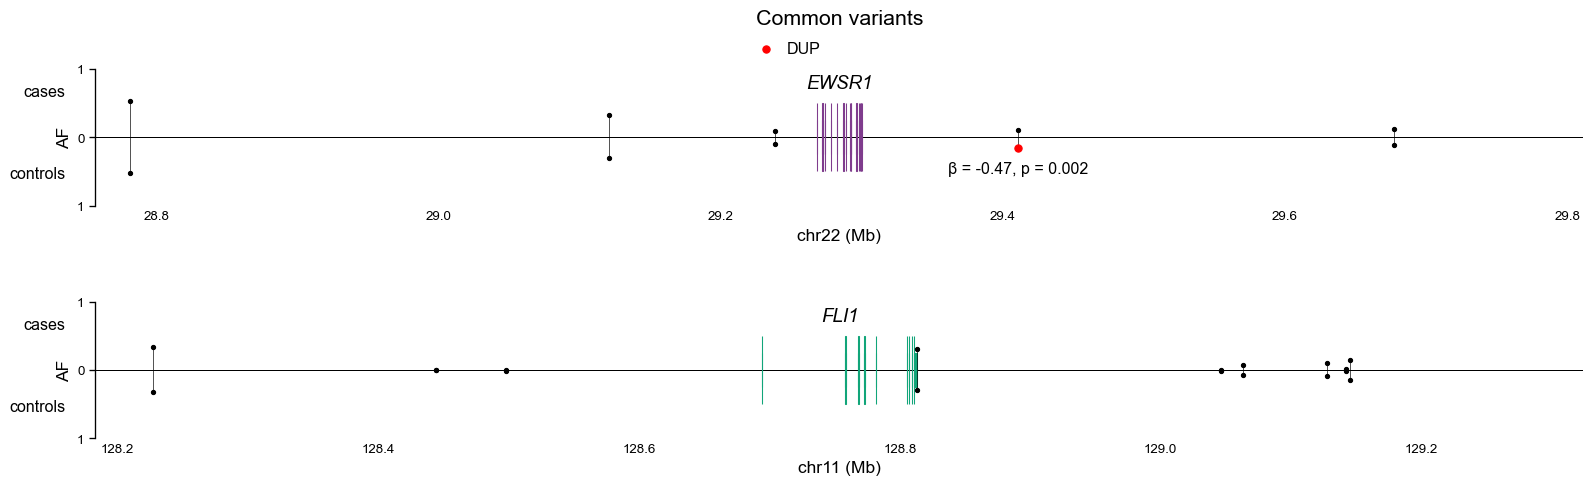

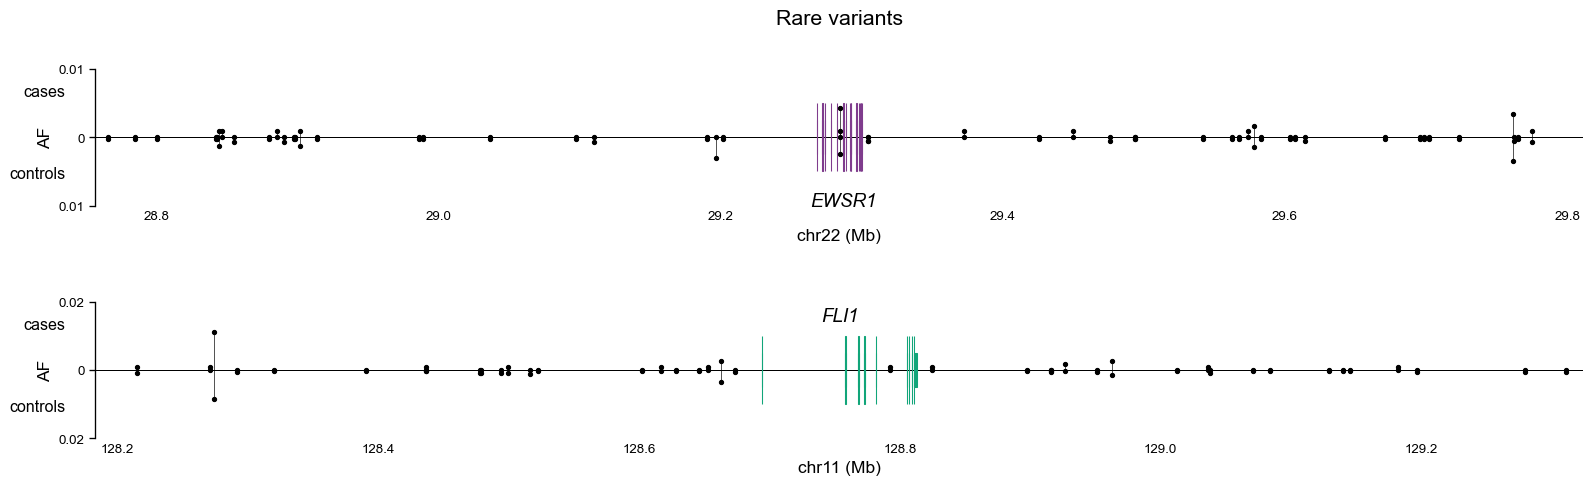

In [62]:
sv_colors = {"DEL": "blue", "DUP": "red"}

for plot in ["common", "rare"]:

    fig, axes = plt.subplots(
        len(expanded_gene_locs),
        1,
        figsize=(20, 2.5 * len(expanded_gene_locs)),
        gridspec_kw={"hspace": 0.7},
    )

    for i, g in enumerate(expanded_gene_locs["gene"]):

        ax = axes[i]
        g_gtf = gene_gtfs[g]

        # plot the genetic elements
        feature_colors = {"exon": bold_10[i], "CDS": bold_10[i]}
        window = expanded_gene_locs.loc[g, ["start", "end"]].values
        feature_span = {"exon": 0.25, "CDS": 0.5}

        ax = sv_plot.plot_genomic_elements(
            ax,
            g_gtf,
            window=window,
            feature_span=feature_span,
            feature_colors=feature_colors,
            label=False,
        )
        aesthetics.strip_axis(ax=ax, x="label", y="ignore")

        contig = expanded_gene_locs.loc[g, "chrom"]
        if plot == 'rare' and g == 'EWSR1':
            ax.text(x = 0.48, y = 0, s = g, transform = ax.transAxes, fontstyle = 'italic', fontsize = 14)
        else:
            ax.set_title(g, fontstyle="italic", y=0.80)

        # plot the range of interest
        ax.set_xlim(
            expanded_gene_locs.loc[g, ["start", "end"]].values
            + np.array([-10000, 10000])
        )
        ax.spines["bottom"].set_bounds(
            expanded_gene_locs.loc[g, ["start", "end"]].values
        )

        # add labels
        ax.text(s="cases", x=-0.02, y=0.8, transform=ax.transAxes, ha="right")
        ax.text(s="controls", x=-0.02, y=0.2, transform=ax.transAxes, ha="right")

        # switch to Mb
        ax.set_xticklabels(ax.get_xticks() / 1e6)
        ax.set_xlabel(f"{contig} (Mb)")

    # next we add in the SVs. First subset to the SVs in question
    if plot == "common":
        plot_svs = case_control_sv_counts.query("rare == False").copy()
    elif plot == "rare":
        plot_svs = case_control_sv_counts.query("rare == True").copy()

    legend_handles = {}
    for i, gene in enumerate(expanded_gene_locs["gene"]):

        ax = axes[i]
        gene_data = plot_svs[plot_svs["gene"] == gene].reset_index()

        # get the max frequency
        max_freq = gene_data[["AF_cases", "AF_controls"]].max().max()

        if plot == "common":
            rounded_max = 1
        if plot == "rare":
            rounded_max = math.ceil(max_freq * 100) / 100

        # its much easier to plot everything at once with plt.stem, but that function sucks
        # we scale the frequency to fill the plot
        case_y = (gene_data["AF_cases"]) / rounded_max
        control_y = (gene_data["AF_controls"]) / rounded_max

        # add the points
        ax.scatter(x=gene_data["midpoint"], y=case_y, color="black", s=10, zorder=3)
        ax.scatter(x=gene_data["midpoint"], y=-control_y, color="black", s=10, zorder=3)

        # add the lollipop lines
        for j in range(len(gene_data)):
            loc = gene_data["midpoint"][j]
            name = gene_data["name"][j]

            case, control = case_y[j], control_y[j]

            ax.plot(
                [loc, loc],
                [case, -control],
                color="black",
                linewidth=0.5,
                zorder=3,
            )

            # look up the p value of the sv, if it exists
            if name in sv_results.index:
                p_val, coeff = sv_results.loc[name, ["p_bonferroni", "coeff"]]

                if p_val < 0.1:

                    y = case if coeff > 0 else -control
                    text_y = y + 0.3 if coeff > 0 else y - 0.3

                    sv_type = svs_to_keep.set_index("name").loc[name, "svtype"]
                    color = sv_colors.get(sv_type)

                    scatter = ax.scatter(
                        [loc], [y], color=color, s=30, zorder=3, label=sv_type
                    )

                    if sv_type in ["DUP", "DEL"]:
                        legend_handles[sv_type] = scatter

                    # add text for coeff
                    ax.text(
                        x=loc,
                        y=text_y,
                        s=f"β = {round(coeff, 2)}, p = {p_val:.1}",
                        ha="center",
                        va="center",
                    )

        ax.set_yticks([-1, 0, 1])
        ax.set_yticklabels([rounded_max, 0, rounded_max])
        ax.set_ylabel("AF")

    # add a title - can't use suptitle because that doesn't center over the gene
    axes[0].text(
        s=plot.capitalize() + " variants",
        x=0.5,
        y=1.3,
        transform=axes[0].transAxes,
        ha="center",
        va="bottom",
        fontsize=16,
    )

    axes[0].legend(
        handles=legend_handles.values(),
        labels=legend_handles.keys(),
        bbox_to_anchor=(0.43, 1.15),
        ncol=2,
        handletextpad=0.3,
    )

    # fig.savefig(f"images/ewsr1-fli1-discovery-{plot}.png")

In [63]:
case_control_sv_counts = case_control_sv_counts.merge(sv_results, on = 'name')

### Some quick observations

I do want to make a quick note of at least two observations:

In [64]:
sv_results.query("p_bonferroni < 0.1")

,p,coeff,num_cases_dropped,num_controls_dropped,p_bonferroni
name,,,,,
PedSV.2.5.2_DUP_chr22_449,0.000024,-0.469457,0,0,0.002477


In [214]:
# case_control_sv_counts.to_csv('data/ewsr1-fli1-discovery-cohort-loci-v2.4.csv', index=False)

# Examine pairwise analyses - THIS SECTION IS NOT UPDATED WITH THE NEW DATASET

Ryan had an interesting suggestion, which was to examine pairwise connections between EWSR1 and FLI1. The underlying logic is that perhaps there are SVs that predispose to rearrangement, and if they are present on both genes, they enhance the changes of rearrangement.

We're going to try lowering the rare SV threshold to 0.001, although this will yield many more false positives.

This shouldn't be that hard to do. We'll just construct the model dataset with all common SV pairs. Note that I'll also be running a fully joint model, i.e.

`disease ~ ewsr1 + fli1 + ewsr1:fli1 + covariates`

There's an open question of whether the interaction term should be binary or incorporate allele copy number (i.e. be 0, 1, 2, 4). I'm going to go with the latter for now, but it makes interpretation a bit harder.

## Deriving the odds ratios

A key component of this analysis will be accurately interpreting the interaction term. The interaction term is complicated--it does not exist on the same scale as the individual SV terms. To enhance interpretability, I'll calculate three odds-ratios:

1. The odds ratio of `ewsr1`. This represents the increase in odds when the sample has the EWSR1 sv.
2. The odds ratio of `fli1`. This represents the increase in odds when the sample has the FLI1 sv.
3. The odds ratio of _combined_ `ewsr1` and `fli1`, the increase in odds when the sample has both.

The last term is _not_ strictly governed by the interaction term - it represents the first two odds ratios combined AND includes the interaction terms. Models don't output this value--we need to calculate it ourselves. Following https://pubmed.ncbi.nlm.nih.gov/9789916/, we derive the following:

1. The odds ratio for the combined term is `exp(b1 + b2 + b3)`, where b1, b2, and b3 represent the coefficients of the individual SV terms (b1 and b2) and the interaction term (b3). This follows from the multiplicative nature of the logit model.
2. The confidence interval is much harder. The standard error of any coefficient in a GLM is given by `sqrt(var(coef))`, where `var(coef)` is given by the model's covariance matrix. But here we are dealing with a linear combination of coefficients (`b1 + b2 + b3`), so the variance is given by 

$$var(\beta_1 + \beta_2 + \beta_3) = var(β_1) + var(β_2) + var(β_3) + 2Cov(β_1, β_2) + 2Cov(β_1, β_3) + 2Cov(β_2, β_3)$$

The confidence interval is then the odds ratio +/- 1.96 * sqrt(var). We use the normal approximation (1.96 * SE) because we have a decently large number of samples.

To incorporate this into the model, we'll simply create a new row that refers to `combined`.

We can also calculate a p value fairly easily.

In [67]:
# given a statsmodel, return the coeff, SE, and confidence interval for the combined term
def derive_combined_params(model, var_1, var_2, var_int):
    """Given a models results, add a new row reflecting the combined term.
    var_1 and var_2 represent the names of individual terms, the int_var
    represents the name of the interaction variable.

    Expected input is a statsmodels model. Output is (coef, se, z, p)
    """

    # get model results and covariance matrix
    model_results = pd.read_html(
        joint_model.summary().tables[1].as_html(), header=0, index_col=0
    )[0]
    cov_mat = model.cov_params()

    # coef = b1 + b2 + b3
    coeff_combined = model_results.loc[[var_1, var_2, var_int], "coef"].sum()

    # calculate var(b1 + b2 + b3)
    var_combined = (
        cov_mat.loc[var_1, var_1]
        + cov_mat.loc[var_2, var_2]
        + cov_mat.loc[var_int, var_int]
        + 2 * cov_mat.loc[var_1, var_2]
        + 2 * cov_mat.loc[var_1, var_int]
        + 2 * cov_mat.loc[var_2, var_int]
    )
    se_combined = np.sqrt(var_combined)

    # calculate z value of x = 0 (for hypothesis testing)
    z = (coeff_combined - 0) / se_combined

    # calculate p value - two sided
    p = 2 * stats.norm.cdf(z)

    return coeff_combined, se_combined, z, p

## Actually calculate the joint models

In [68]:
# drop the AF cutoff, just in case there's some really strong signal we miss
svs_to_keep_pairwise = subsetted_gene_dosages[["name", "gene", "AF"]].copy()
svs_to_keep_pairwise["rare"] = subsetted_gene_dosages["AF"] < 0.001

In [69]:
ewsr1_common_svs = svs_to_keep_pairwise[
    (svs_to_keep_pairwise["gene"] == "EWSR1") & (~svs_to_keep_pairwise["rare"])
]["name"].to_list()
fli1_common_svs = svs_to_keep_pairwise[
    (svs_to_keep_pairwise["gene"] == "FLI1") & (~svs_to_keep_pairwise["rare"])
]["name"].to_list()

In [70]:
len(fli1_common_svs) * len(ewsr1_common_svs)

208

In [71]:
len(fli1_common_svs), len(ewsr1_common_svs)

(16, 13)

We make combinations of these

In [72]:
combinations = [(ewsr1, fli1) for ewsr1 in ewsr1_common_svs for fli1 in fli1_common_svs]

In [73]:
columns = [
    "entity:sample_id",
    "disease",
    "sex",
] + [col for col in metadata.columns if col in ['PC1', 'PC2', 'PC3']]

model_samples = ewings_samples + control_samples
model_data = metadata[metadata["entity:sample_id"].isin(model_samples)][
    columns
].set_index("entity:sample_id")

# annoying reformatting
model_data["disease"] = model_data["disease"].replace({"ewing": 1, "control": 0})

Next we build our "dosage matrix", where a sample gets 1 if it has both SVs and 0 otherwise. This is going to get a bit complicated, as we run several models in one.

In [74]:
joint_sv_models = {}
joint_sv_results = []

for combo in combinations:

    # extract which SVs are part of this combo
    ewsr1_sv, fli1_sv = combo
    joint_sv = "+".join(combo)

    # to store results
    df_row = []

    # get the gene dosages
    ewsr1_dosage = subsetted_gene_dosages.set_index("name").loc[ewsr1_sv, model_samples]
    fli1_dosage = subsetted_gene_dosages.set_index("name").loc[fli1_sv, model_samples]

    # extract single and joint dosages
    combo_dosage = ewsr1_dosage * fli1_dosage

    # fill in model data - single SVs and combos
    model_data.loc[ewsr1_dosage.index, ewsr1_sv] = ewsr1_dosage.astype(float)
    model_data.loc[fli1_dosage.index, fli1_sv] = fli1_dosage.astype(float)
    model_data.loc[combo_dosage.index, joint_sv] = combo_dosage.astype(float)

    # run the joint model
    endog = model_data["disease"]
    exog_joint = sm.tools.add_constant(
        model_data[[ewsr1_sv, fli1_sv, joint_sv] + columns[2:]]
    )

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        joint_model = sm.Logit(endog=endog, exog=exog_joint, missing="drop").fit(
            disp=0, method="bfgs", maxiter=1000
        )

    joint_sv_models[joint_sv] = joint_model

    # fetch model results in df form
    model_results = pd.read_html(
        joint_model.summary().tables[1].as_html(), header=0, index_col=0
    )[0]

    # do some extensive reformatting
    model_results = model_results.iloc[1:4]
    model_results.index = ["ewsr1 joint", "fli1 joint", "interaction"]
    model_results = model_results.reset_index().rename(columns={"index": "component"})

    # add in the COMBINED results
    try:
        combined_coef, combined_se, z, p = derive_combined_params(
            joint_model, ewsr1_sv, fli1_sv, joint_sv
        )
        model_results.loc[3] = [
            "combined",
            combined_coef,
            combined_se,
            z,
            p,
            combined_coef - 1.96 * combined_se,
            combined_coef + 1.96 * combined_se,
        ]

    # will fail if model did not fit
    except:
        model_results.loc[3] = ["combined"] + [np.nan] * 6

    # add in the single model results
    for gene, sv in zip(["ewsr1", "fli1"], [ewsr1_sv, fli1_sv]):

        # get model
        single_gene_model = sv_models[sv].summary().tables[1]
        single_gene_results = pd.read_html(
            single_gene_model.as_html(), header=0, index_col=0
        )[0].iloc[1]
        single_gene_results.loc["component"] = f"{gene} single"
        model_results = model_results.append(single_gene_results)

    model_results.insert(0, "joint_sv", ewsr1_sv + "+" + fli1_sv)
    model_results = model_results.reset_index(drop=True)

    joint_sv_results.append(model_results)

joint_sv_results = pd.concat(joint_sv_results).reset_index(drop=True)
joint_sv_results.columns = [
    "joint_sv",
    "component",
    "coef",
    "se",
    "z",
    "p",
    "[0.025",
    "0.975]",
]

We can add in odds ratio data here as well. Note that the odds ratio metric for the interaction term is meaningless (or rather, in the incorrect scale), so we reset those.

In [75]:
joint_sv_results["odds_ratio"] = np.exp(joint_sv_results["coef"])
joint_sv_results["odds_ratio_[0.025"] = np.exp(joint_sv_results["[0.025"])
joint_sv_results["odds_ratio_0.975]"] = np.exp(joint_sv_results["0.975]"])

# find and reset the interaction terms
interaction_indices = np.where(joint_sv_results["component"] == "interaction")[0]
joint_sv_results.loc[
    interaction_indices, ["odds_ratio", "odds_ratio_[0.025", "odds_ratio_0.975]"]
] = np.nan

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


We get some `nan` due to overflow errors--these happen when coefficient estimation is so poor that they're massively inflated. Converting to odds ratios then overflows. We don't believe any of these any way.

In [76]:
joint_sv_results = joint_sv_results.set_index("joint_sv")

In [77]:
joint_sv_results.head(6)

,component,coef,se,z,p,[0.025,0.975],odds_ratio,odds_ratio_[0.025,odds_ratio_0.975]
joint_sv,,,,,,,,,,
PedSV.2.5.2_INS_chr22_339+PedSV.2.5.2_DEL_chr11_9459,ewsr1 joint,0.0058,2.040000e-01,2.900000e-02,0.977000,-3.930000e-01,4.050000e-01,1.005817,0.675029,1.499303
PedSV.2.5.2_INS_chr22_339+PedSV.2.5.2_DEL_chr11_9459,fli1 joint,0.4206,6.500000e+06,6.470000e-08,1.000000,-1.270000e+07,1.270000e+07,1.522875,0.000000,inf
PedSV.2.5.2_INS_chr22_339+PedSV.2.5.2_DEL_chr11_9459,interaction,0.4206,6.500000e+06,6.470000e-08,1.000000,-1.270000e+07,1.270000e+07,NaN,NaN,NaN
PedSV.2.5.2_INS_chr22_339+PedSV.2.5.2_DEL_chr11_9459,combined,0.8470,1.243734e+00,6.810136e-01,1.504137,-1.590719e+00,3.284719e+00,2.332638,0.203779,26.701486
PedSV.2.5.2_INS_chr22_339+PedSV.2.5.2_DEL_chr11_9459,ewsr1 single,0.0054,2.040000e-01,2.700000e-02,0.979000,-3.930000e-01,4.040000e-01,1.005415,0.675029,1.497804
PedSV.2.5.2_INS_chr22_339+PedSV.2.5.2_DEL_chr11_9459,fli1 single,0.8429,1.222000e+00,6.900000e-01,0.490000,-1.551000e+00,3.237000e+00,2.323094,0.212036,25.457235


In [78]:
joint_sv_results.query('component == "interaction" & p < 0.05')

,component,coef,se,z,p,[0.025,0.975],odds_ratio,odds_ratio_[0.025,odds_ratio_0.975]
joint_sv,,,,,,,,,,
PedSV.2.5.2_INS_chr22_356+PedSV.2.5.2_DEL_chr11_9485,interaction,-0.4722,0.135,-3.498,0.000,-0.737,-0.208,NaN,NaN,NaN
PedSV.2.5.2_DEL_chr22_1513+PedSV.2.5.2_INS_chr11_3729,interaction,1.1447,0.517,2.213,0.027,0.131,2.158,NaN,NaN,NaN
PedSV.2.5.2_DEL_chr22_1516+PedSV.2.5.2_INS_chr11_3741,interaction,3.0724,1.399,2.196,0.028,0.331,5.814,NaN,NaN,NaN
PedSV.2.5.2_DUP_chr22_457+PedSV.2.5.2_DUP_chr11_2453,interaction,0.3185,0.162,1.969,0.049,0.002,0.636,NaN,NaN,NaN


Interesting... some of these are definitely plausible. Let's check one in particular:

In [79]:
joint_sv_results.loc['PedSV.2.5.2_INS_chr22_356+PedSV.2.5.2_DEL_chr11_9485']

,component,coef,se,z,p,[0.025,0.975],odds_ratio,odds_ratio_[0.025,odds_ratio_0.975]
joint_sv,,,,,,,,,,
PedSV.2.5.2_INS_chr22_356+PedSV.2.5.2_DEL_chr11_9485,ewsr1 joint,0.4840,0.129000,3.763000,0.000000,0.232000,0.736000,1.622552,1.261120,2.087569
PedSV.2.5.2_INS_chr22_356+PedSV.2.5.2_DEL_chr11_9485,fli1 joint,0.3163,0.107000,2.945000,0.003000,0.106000,0.527000,1.372042,1.111822,1.693843
PedSV.2.5.2_INS_chr22_356+PedSV.2.5.2_DEL_chr11_9485,interaction,-0.4722,0.135000,-3.498000,0.000000,-0.737000,-0.208000,NaN,NaN,NaN
PedSV.2.5.2_INS_chr22_356+PedSV.2.5.2_DEL_chr11_9485,combined,0.3281,0.126938,2.584718,1.990254,0.079301,0.576899,1.388328,1.082530,1.780509
PedSV.2.5.2_INS_chr22_356+PedSV.2.5.2_DEL_chr11_9485,ewsr1 single,0.1864,0.094000,1.974000,0.048000,0.001000,0.372000,1.204904,1.001001,1.450633
PedSV.2.5.2_INS_chr22_356+PedSV.2.5.2_DEL_chr11_9485,fli1 single,0.0239,0.069000,0.348000,0.728000,-0.111000,0.159000,1.024188,0.894939,1.172338


In this instance, I don't actually believe any of these values. They're all not that significantly different from 0.

In [80]:
ewsr1_sig = joint_sv_results.query('component == "ewsr1 joint"')["p"] > 0.05
fli1_sig = joint_sv_results.query('component == "fli1 joint"')["p"] > 0.05

ewsr1_sig = ewsr1_sig.index[np.where(ewsr1_sig)[0]]
fli1_sig = fli1_sig.index[np.where(fli1_sig)[0]]

nonsig_single_svs = set(ewsr1_sig) & set(fli1_sig)

potential_synergies = joint_sv_results.loc[nonsig_single_svs][
    lambda row: (row["component"] == "interaction") & (row["p"] < 0.05)
]

potential_synergies

,component,coef,se,z,p,[0.025,0.975],odds_ratio,odds_ratio_[0.025,odds_ratio_0.975]
joint_sv,,,,,,,,,,
PedSV.2.5.2_DUP_chr22_457+PedSV.2.5.2_DUP_chr11_2453,interaction,0.3185,0.162,1.969,0.049,0.002,0.636,NaN,NaN,NaN


So three potential SVs here. It's not obvious to me that these are the only ones we want, but they certainly are interesting.

What about SVs where the interaction term AND combined odds ratio is significant?

In [81]:
interaction_sig = joint_sv_results.query('component == "interaction"')["p"] < 0.05
combined_sig = joint_sv_results.query('component == "combined"')["p"] < 0.05

interaction_sig = interaction_sig.index[np.where(interaction_sig)[0]]
combined_sig = combined_sig.index[np.where(combined_sig)[0]]

sig_indices = set(interaction_sig) & set(combined_sig)

potential_synergies = joint_sv_results.loc[interaction_sig].query('component == "combined"')

potential_synergies

,component,coef,se,z,p,[0.025,0.975],odds_ratio,odds_ratio_[0.025,odds_ratio_0.975]
joint_sv,,,,,,,,,,
PedSV.2.5.2_INS_chr22_356+PedSV.2.5.2_DEL_chr11_9485,combined,0.3281,0.126938,2.584718,1.990254,0.079301,0.576899,1.388328,1.082530,1.780509
PedSV.2.5.2_DEL_chr22_1513+PedSV.2.5.2_INS_chr11_3729,combined,-0.5773,0.481860,-1.198067,0.230891,-1.521745,0.367145,0.561412,0.218331,1.443607
PedSV.2.5.2_DEL_chr22_1516+PedSV.2.5.2_INS_chr11_3741,combined,3.5770,1.164649,3.071312,1.997869,1.294288,5.859712,35.766081,3.648397,350.623165
PedSV.2.5.2_DUP_chr22_457+PedSV.2.5.2_DUP_chr11_2453,combined,0.1116,0.122572,0.910484,1.637432,-0.128642,0.351842,1.118066,0.879289,1.421683


### Following up with some plots

There are a _ton_ of variants to cover here, ad they're not all easy to interpret. I think the most convincing evidence, if it exists, will be just straight up allele fraction or odds ratio plots. We'll make both for any result with a significant p value. By definition, this includes an enormous number of false positives.

In [82]:
significant_results = joint_sv_results.query("p < 0.05")
significant_joint_svs = sorted(set(significant_results.index))

In [83]:
len(significant_joint_svs)

70

In [ ]:
for joint_sv in significant_joint_svs:
    ewsr1_sv, fli1_sv = joint_sv.split("+")

    fig = plt.figure(figsize=(13, 3))

    # make the overall gridspec - divides gene body from coverage
    overall_gs = fig.add_gridspec(1, 2, wspace=0.3, width_ratios=[8, 5])
    gene_gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=overall_gs[0], hspace=0.6)

    joint_sv_params = joint_sv_results.loc[joint_sv].reset_index().set_index("component")
    joint_sv_params = joint_sv_params.loc[
        [
            "ewsr1 single",
            "fli1 single",
            "ewsr1 joint",
            "fli1 joint",
            "interaction",
            "combined",
        ]
    ]

    ax = fig.add_subplot(overall_gs[1])

    # plot the points and confidence intervals
    loc = 0
    for index, row in joint_sv_params.iterrows():

        # interactions aren't plotted
        if index == "interaction":
            continue

        # odds ratio and confidence interval
        if not np.isnan(row["[0.025"]):
            ax.scatter([loc], [row["coef"]], color="black")
            
            if row['[0.025'] < -10 or row["0.975]"] > 10:
                bottom, top = -10, 10
            else:
                bottom, top = row['[0.025'], row["0.975]"]

            ax.plot([loc, loc], [bottom, top], color="black")

        p = row["p"]
        if p < 0.05:
            p_formatted = f"p = {p:.1g}"
            y = row["0.975]"]

            ax.text(s=p_formatted, x=loc, y=y + 0.1, ha="center", va="bottom", fontsize=10)

        if index != "fli1 single":
            loc += 1
        else:
            loc += 1.5

    ax.axhline(y=0, color="darkgrey", linestyle="dashed", zorder=0)
    aesthetics.strip_axis(ax, y="ignore", x="label")
    ax.set_xticks([0.5, 3.5])

    # if the interaction term is significant, add it to the plot
    xlabels = ["Single model", "Joint model"]
    p_int = joint_sv_params.loc["interaction", "p"]
    if p_int < 0.05:
        p_formatted = f"p = {p_int:.1g}"
        beta = joint_sv_params.loc["interaction", "coef"]
        beta_formatted = f"β = {round(beta, 2)}"
        xlabels[1] = f"Joint model\n({p_formatted}, {beta_formatted})"

    ax.set_xticklabels(xlabels)
    ax.tick_params(axis="x", pad=20, labelsize=12)

    y_bottom = ax.get_ylim()[0]
    for loc, label in zip(
        [0, 1, 2.5, 3.5, 4.5], ["EWSR1", "FLI1", "EWSR1", "FLI1", "Combined"]
    ):
        fontstyle = "italic" if label != "Combined" else None
        ax.text(
            s=label,
            x=loc,
            y=y_bottom,
            ha="center",
            va="top",
            fontstyle=fontstyle,
            fontsize=10,
        )
    ax.set_xlim([-0.5, 5])
    ax.set_ylabel("Normalized\nlog odds ratio")

    # next, we add the genes for visualization purposes.
    axes = []
    for i, g in enumerate(expanded_gene_locs["gene"]):

        ax = fig.add_subplot(gene_gs[i])
        axes.append(ax)

        g_gtf = gene_gtfs[g]

        # plot the genetic elements
        feature_colors = {"exon": bold_10[i], "CDS": bold_10[i]}
        window = expanded_gene_locs.loc[g, ["start", "end"]].values
        feature_span = {"exon": 0.25, "CDS": 0.5}

        ax = sv_plot.plot_genomic_elements(
            ax,
            g_gtf,
            window=window,
            feature_span=feature_span,
            feature_colors=feature_colors,
            label=False,
        )
        aesthetics.strip_axis(ax=ax, x="label", y="ignore")

        contig = expanded_gene_locs.loc[g, "chrom"]
        ax.set_title(g, fontstyle="italic", y=0.80, fontsize=12)

        # plot the range of interest
        ax.set_xlim(
            expanded_gene_locs.loc[g, ["start", "end"]].values + np.array([-10000, 10000])
        )
        ax.spines["bottom"].set_bounds(expanded_gene_locs.loc[g, ["start", "end"]].values)

        # add labels
        ax.text(s="cases", x=-0.02, y=0.8, transform=ax.transAxes, ha="right", fontsize=8)
        ax.text(s="controls", x=-0.02, y=0.2, transform=ax.transAxes, ha="right", fontsize=8)

        # switch to Mb
        ax.set_xticklabels(ax.get_xticks() / 1e6)
        ax.set_xlabel(f"{contig} (Mb)", fontsize=10)

    # add the data for the SVs in question
    for i, (gene, sv) in enumerate(zip(['EWSR1', 'FLI1'], [ewsr1_sv, fli1_sv])):
        
        # sometimes SVs are dropped from the original df if they didn't pass single testing. We ignore these.
        if sv in case_control_sv_counts['name'].to_list():
            sv_data = case_control_sv_counts.set_index('name').loc[sv]
        else:
            continue

        x = sv_data['midpoint']
        y = sv_data[['AF_cases', 'AF_controls']]

        max_freq = y.max() * 2
        rounded_max = min(1, math.ceil(max_freq * 100) / 100)

        y = y / rounded_max

        # add points
        axes[i].scatter([x, x], [y[0], -y[1]], color = 'black')
        axes[i].plot([x, x], [y[0], -y[1]], color = 'black')

        axes[i].set_yticklabels([rounded_max, 0, rounded_max])
        axes[i].set_ylabel("AF", fontsize=10)

    sv_types = svs_to_keep.set_index('name').loc[[ewsr1_sv, fli1_sv], 'svtype'].values.astype(str)
    title = f"EWSR1 = {ewsr1_sv} ({sv_types[0]})\nFLI1 = {fli1_sv} ({sv_types[1]})"
    fig.suptitle(title, fontsize=14, y = 1.1)
    
    fig.savefig(f'images/ewsr1-fli1-joint-sv-plots/{joint_sv}.png')
    
    plt.close(fig)

## Plot all SVs

We'll be plotting all SVs and connecting the ones that are significant.

In [87]:
sv_colors = {
    "DEL": "blue",
    "DUP": "red",
    "INS:ME:ALU": bold_10[0],
    "INS:ME:LINE1": bold_10[1],
}

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator


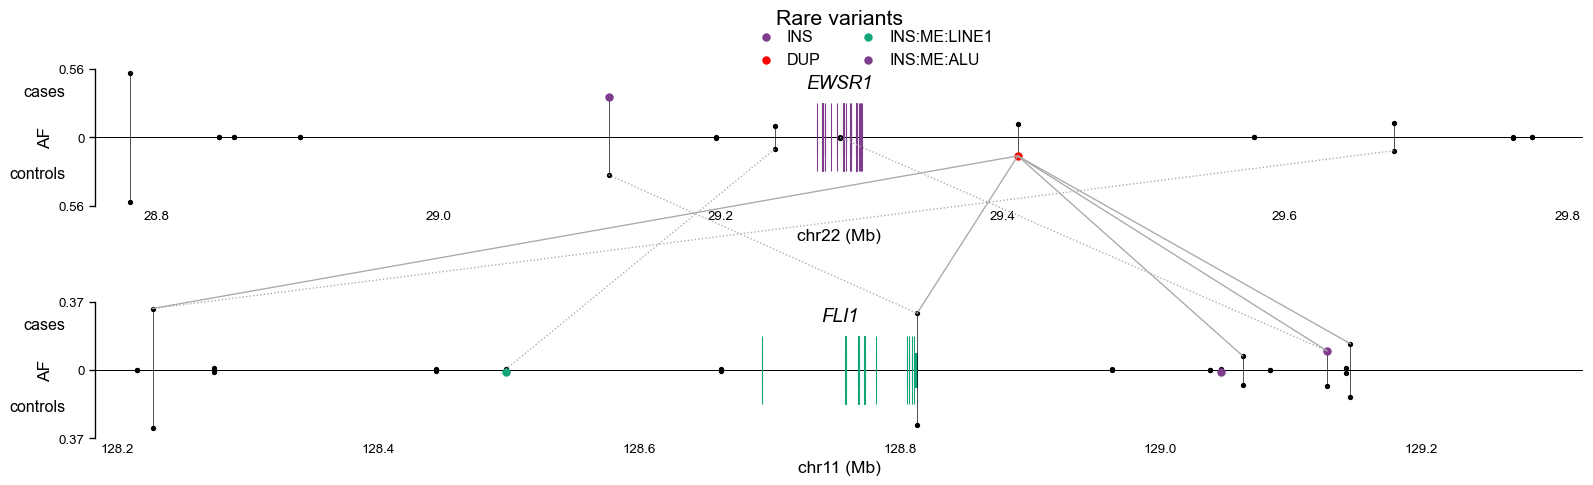

In [88]:
fig, axes = plt.subplots(
    len(expanded_gene_locs),
    1,
    figsize=(20, 2.5 * len(expanded_gene_locs)),
    gridspec_kw={"hspace": 0.7},
)

for i, g in enumerate(expanded_gene_locs["gene"]):

    ax = axes[i]
    g_gtf = gene_gtfs[g]

    # plot the genetic elements
    feature_colors = {"exon": bold_10[i], "CDS": bold_10[i]}
    window = expanded_gene_locs.loc[g, ["start", "end"]].values
    feature_span = {"exon": 0.25, "CDS": 0.5}

    ax = sv_plot.plot_genomic_elements(
        ax,
        g_gtf,
        window=window,
        feature_span=feature_span,
        feature_colors=feature_colors,
        label=False,
    )
    aesthetics.strip_axis(ax=ax, x="label", y="ignore")

    contig = expanded_gene_locs.loc[g, "chrom"]
    ax.set_title(g, fontstyle="italic", y=0.80)

    # plot the range of interest
    ax.set_xlim(
        expanded_gene_locs.loc[g, ["start", "end"]].values + np.array([-10000, 10000])
    )
    ax.spines["bottom"].set_bounds(expanded_gene_locs.loc[g, ["start", "end"]].values)

    # add labels
    ax.text(s="cases", x=-0.02, y=0.8, transform=ax.transAxes, ha="right")
    ax.text(s="controls", x=-0.02, y=0.2, transform=ax.transAxes, ha="right")

    # switch to Mb
    ax.set_xticklabels(ax.get_xticks() / 1e6)
    ax.set_xlabel(f"{contig} (Mb)")

# next we add in the SVs. First subset to the SVs in question
plot_svs = case_control_sv_counts.query("AF > 0.001")

legend_handles = {}
sv_locations = {"EWSR1": {}, "FLI1": {}}
for i, gene in enumerate(expanded_gene_locs["gene"]):

    ax = axes[i]
    gene_data = plot_svs[plot_svs["gene"] == gene].reset_index()

    # get the max frequency
    max_freq = gene_data[["AF_cases", "AF_controls"]].max().max()
    rounded_max = math.ceil(max_freq * 100 + 3) / 100

    # its much easier to plot everything at once with plt.stem, but that function sucks
    # we scale the frequency to fill the plot
    case_y = (gene_data["AF_cases"]) / rounded_max
    control_y = (gene_data["AF_controls"]) / rounded_max

    # add the points
    ax.scatter(x=gene_data["midpoint"], y=case_y, color="black", s=10, zorder=3)
    ax.scatter(x=gene_data["midpoint"], y=-control_y, color="black", s=10, zorder=3)

    # add the lollipop lines
    for j in range(len(gene_data)):
        loc = gene_data["midpoint"][j]
        name = gene_data["name"][j]

        case, control = case_y[j], control_y[j]

        ax.plot(
            [loc, loc],
            [case, -control],
            color="black",
            linewidth=0.5,
            zorder=3,
        )

        # store the results
        storage = [loc, -control] if gene == "EWSR1" else [loc, case]
        sv_locations[gene][name] = storage

        # look up the p value of the single model sv, if it exists
        if name in sv_results.index:
            p_val, coeff = sv_results.loc[name, ["p", "coeff"]]

            if p_val < 0.05:

                y = case if coeff > 0 else -control
                text_y = y + 0.3 if coeff > 0 else y - 0.3

                sv_type = svs_to_keep.set_index("name").loc[name, "svtype"]
                color = sv_colors.get(sv_type)

                scatter = ax.scatter(
                    [loc], [y], color=color, s=30, zorder=4, label=sv_type
                )
                legend_handles[sv_type] = scatter

    ax.set_yticks([-1, 0, 1])
    ax.set_yticklabels([rounded_max, 0, rounded_max])
    ax.set_ylabel("AF")

# add a title - can't use suptitle because that doesn't center over the gene
axes[0].text(
    s=plot.capitalize() + " variants",
    x=0.5,
    y=1.3,
    transform=axes[0].transAxes,
    ha="center",
    va="bottom",
    fontsize=16,
)

axes[0].legend(
    handles=legend_handles.values(),
    labels=legend_handles.keys(),
    bbox_to_anchor=(0.43, 1.15),
    ncol=2,
    handletextpad=0.3,
)

# connect using joint SV model
for ewsr1_sv, fli1_sv in combinations:
    joint_sv = ewsr1_sv + "+" + fli1_sv
    joint_sv_res = joint_sv_results.loc[joint_sv]

    int_p, combined_p = joint_sv_res.set_index("component").loc[
        ["interaction", "combined"], "p"
    ]

    # get the coordinates
    if ewsr1_sv in sv_locations["EWSR1"] and fli1_sv in sv_locations["FLI1"]:
        ewsr1_coord = sv_locations["EWSR1"][ewsr1_sv]
        fli1_coord = sv_locations["FLI1"][fli1_sv]
    else:
        continue

    ewsr1_fig = fig.transFigure.inverted().transform(
        axes[0].transData.transform(ewsr1_coord)
    )
    fli1_fig = fig.transFigure.inverted().transform(
        axes[1].transData.transform(fli1_coord)
    )

    fig_x = [ewsr1_fig[0], fli1_fig[0]]
    fig_y = [ewsr1_fig[1], fli1_fig[1]]

    linestyles = ["dotted", None]
    for i, p in enumerate([int_p, combined_p]):
        if p < 0.05:
            fig.add_artist(
                Line2D(
                    fig_x,
                    fig_y,
                    color="darkgrey",
                    linestyle=linestyles[i],
                    zorder=1,
                    linewidth=1,
                )
            )
            
fig.savefig('images/ewsr1-fli1-joint-sv-model-results.png')